# What makes a playlist successful?

**Analysis**

* Simple metric (dependent variable)
    * mau_previous_month
    * mau_both_months
    * monthly_stream30s
    * stream30s
* Design metric (dependent variable)
    * 30s listens/tot listens (listen conversions)
    * Users both months/users prev month (user conversions)
    * Best small time performers (less than X total monthly listens + high conversion)
    * Best new user playlist (owner has only 1 popular playlist)
* Define "top"
    * Top 10%
        * mau_previous_month: 9.0
        * mau_both_months: 2.0
        * mau: 9.0
        * monthly_stream30s: 432.0
        * stream30s: 17.0
    * Top 1%
        * mau_previous_month: 130.0
        * mau_both_months: 19.0
        * mau: 143.0
        * monthly_stream30s: 2843.0
        * stream30s: 113.0
* Independent variables
    * moods and genres (categorical)
    * number of tracks, albums, artists, and local tracks (continuous)
        
The analysis will consist of:

1. understand the distribution characteristics of the dependent and independent variables
2. quantify the dependency of the dependent/independent variables for each of the simple and design metrics
    1. chi-square test
    2. bootstrap/t-test

**Key Conclusions**

for the simple metrics, key genres and moods were **Romantic, Latin, Children's, Lively, Traditional, and Jazz**. Playlists that included these genres/moods had a positive multiplier effect (usually in the vicinicty of 2x more likely) on the key simple metric (i.e. playlists with latin as a primary genre were 2.5x more likely to be in the top 10% of streams longer than 30 seconds)

skippers - is this associated with the current playlist 

| Column Name             | Description                                                                                              |
|-------------------------|----------------------------------------------------------------------------------------------------------|
| playlist_uri            | The key, Spotify uri of the playlist                                                                     |
| owner                   | Playlist owner, Spotify username                                                                         |
| streams                 | Number of streams from the playlist today                                                                |
| stream30s               | Number of streams over 30 seconds from playlist today                                                    |
| dau                     | Number of Daily Active Users, i.e. users with a stream over 30 seconds from playlist today               |
| wau                     | Number of Weekly Active Users, i.e. users with a stream over 30 seconds from playlist in past week       |
| mau                     | Number of Monthly Active Users, i.e. users with a stream over 30 seconds from playlist in the past month |
| mau_previous_months     | Number of Monthly Active users in the month prior to this one                                            |
| mau_both_months         | Number of users that were active on the playlist both this and the previous month                        |
| users                   | Number of users streaming (all streams) from this playlist this month                                    |
| skippers                | Number of users who skipped more than 90 percent of their streams today                                  |
| owner_country           | Country of the playlist owner                                                                            |
| n_tracks                | Number of tracks in playlist                                                                             |
| n_local_tracks          | Change in number of tracks on playlist since yesterday                                                   |
| n_artists               | Number of unique artists in playlist                                                                     |
| n_albums                | Number of unique albums in playlist                                                                      |
| monthly_stream30s       | Number of streams over 30 seconds this month                                                             |
| monthly_owner_stream30s | Number of streams over 30 seconds by playlist owner this month                                           |
| tokens                  | List of playlist title tokens, stopwords and punctuation removed                                         |
| genre_1                 | No. 1 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_2                 | No. 2 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| genre_3                 | No. 3 Genre by weight of playlist tracks, from Gracenote metadata                                        |
| mood_1                  | No. 1 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_2                  | No. 2 Mood by weight of playlist tracks, from Gracenote metadata                                         |
| mood_3                  | No. 3 Mood by weight of playlist tracks, from Gracenote metadata                                         |

## Imports

In [1]:
# basic packages
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import random
import copy

# visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


In [2]:
df = pd.read_csv("../../data/playlist_summary_external-4.txt", delimiter='\t')

In [3]:
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,0,US,52,0,4,7,30,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,0,US,131,0,112,113,112,94,"[""good"", ""living""]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,0,US,43,0,35,36,63,0,"[""norte\u00f1a""]",Latin,-,-,Lively,Upbeat,Romantic
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,0,US,27,1,27,26,154,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,1,US,52,0,47,51,230,0,"[""cheesy"", ""pants""]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning


In [8]:
df.tail()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
403361,spotify:user:4672952d42bdd93b9215ce9a40394ea6:...,4672952d42bdd93b9215ce9a40394ea6,18,6,2,6,13,12,8,20,1,US,48,0,44,48,464,43,"[""discover"", ""mix""]",Indie Rock,Alternative,Dance & House,Excited,Yearning,Energizing
403362,spotify:user:28c4378e099b4843f5dd42bb848c78ea:...,28c4378e099b4843f5dd42bb848c78ea,0,0,0,0,2,1,1,3,0,US,182,27,114,129,44,14,"[""ambient"", ""study"", ""music""]",Electronica,Dance & House,Rap,Sensual,Excited,Brooding
403363,spotify:user:1c54302dc7e610a10c51eed81e26a168:...,1c54302dc7e610a10c51eed81e26a168,0,0,0,2,2,0,0,2,0,US,36,0,16,15,82,80,"[""october""]",Rap,Indie Rock,Alternative,Brooding,Defiant,Sophisticated
403364,spotify:user:adc973443cdf1abecdfb4244e530d451:...,adc973443cdf1abecdfb4244e530d451,0,0,0,0,2,0,0,2,0,US,50,0,25,25,2,0,[],Rap,R&B,Latin,Defiant,Energizing,Aggressive
403365,spotify:user:b3752c94e387192b7950b687453bcf45:...,b3752c94e387192b7950b687453bcf45,74,16,1,1,2,1,1,3,1,US,348,10,281,290,216,178,"[""eclecticism""]",Rap,Rock,Alternative,Defiant,Energizing,Cool


In [9]:
df.sort_values('users', ascending=False).head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
152032,spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...,spotify,2527075,1461324,152929,669966,1944150,1478684,578391,3455406,86162,US,51,0,51,51,42497334,22,"[""top"", ""hits""]",Pop,R&B,Dance & House,Excited,Cool,Brooding
163726,spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...,spotify,2629715,1513237,122005,514627,1453097,970905,364140,2448881,56707,US,100,0,93,86,40722305,0,"[""top"", ""tracks"", ""currently"", ""spotify""]",Pop,Dance & House,Indie Rock,Excited,Defiant,Energizing
216752,spotify:user:spotify:playlist:3ZgmfR6lsnCwdffZ...,spotify,735281,348391,43498,219817,688999,365968,109688,1233952,34145,US,100,0,100,99,9879201,0,"[""top"", ""pop"", ""tracks"", ""spotify""]",Pop,R&B,Rap,Excited,Defiant,Empowering
401060,spotify:user:spotify:playlist:3MlpudZs4HT3i0yG...,spotify,505876,245377,33152,121173,430129,339921,79443,973788,23846,US,43,0,41,42,5567649,44,"[""teen"", ""party""]",Pop,R&B,Rap,Excited,Yearning,Urgent
307283,spotify:user:spotify:playlist:04MJzJlzOoy5bTyt...,spotify,252309,124903,16480,68518,278966,448102,75371,917174,11888,US,296,0,1,1,4178965,8,"[""dance"", ""mega"", ""mix""]",Dance & House,Electronica,Pop,Excited,Aggressive,Energizing


In [10]:
df.iloc[403361,0]

'spotify:user:4672952d42bdd93b9215ce9a40394ea6:playlist:6W45lqDBZ1TKma71Uu2F5x'

In [11]:
df.columns

Index(['playlist_uri', 'owner', 'streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'owner_country', 'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'monthly_stream30s', 'monthly_owner_stream30s', 'tokens', 'genre_1',
       'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3'],
      dtype='object')

In [12]:
id = [df.columns[0], df.columns[1]]
targets = list(df.columns[2:11]) + ["monthly_stream30s", "monthly_owner_stream30s"]
features = set(df.columns) - set(targets) - set(id)
features = list(features)

print(f"id columns: {id}")
print(f"target columns: {targets}")
print(f"feature columns: {features}")

id columns: ['playlist_uri', 'owner']
target columns: ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users', 'skippers', 'monthly_stream30s', 'monthly_owner_stream30s']
feature columns: ['n_albums', 'n_artists', 'mood_1', 'n_tracks', 'mood_3', 'genre_1', 'genre_2', 'genre_3', 'tokens', 'owner_country', 'n_local_tracks', 'mood_2']


`stream30s`, `dau`, `wau`, `mau`, `monthly_stream30s`, `monthly_owner_stream30s`, `mau_previous_months` and `mau_both_months` are all specifically for users who have streamed the playlist for over 30 seconds

Let's make the north star metric

* `mau_previous_month` - tells us how many users have streamed over 30 seconds from the playlist this past month
    * **downside**: since we don't know when the playlist was created, we may falsely label some playlists as having low rate of success

Let's make a guardrail metric

* `mau_both_months` - tells us if the playlist has replay value
    * **downside**: since we don't know when the playlist was created, we don't know at what stage the playlist is in its lifetime, i.e. do users fall off from months 1-2 or months 10-11
    
* `stream30s` - number of streams over 30 seconds today; tells us demand of playlist unormalized by number of users accessing the stream (i.e. some users will stream multiple times)
    * **downside** - a few users can dominate the overall number of listens
    
* `monthly_stream30s` - number of streams over 30 seconds for the month; will give us a longer term comparison between streams
    * **downside** - playlists created at some point in the month will be compared unequally
    
Secondary metric

* `monthly_owner_stream30s` - tells us if the owner or the playlist is significant in making a successful playlist; semi-feature column

In [255]:
sub_targets = ['mau_previous_month', 'mau_both_months',  'mau', 'monthly_stream30s', 'stream30s']

## Depenent Variable

it looks like `mau` may be from an incomplete month (comparing the frequency to `mau_previous_months`)

In [830]:
df[targets].corr()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,monthly_stream30s,monthly_owner_stream30s
streams,1.000000,0.994380,0.988381,0.967860,0.958000,0.905523,0.957998,0.911023,0.948062,0.984383,-0.001338
stream30s,0.994380,1.000000,0.985062,0.968307,0.957810,0.908967,0.956223,0.912391,0.937712,0.992060,-0.000767
dau,0.988381,0.985062,1.000000,0.986290,0.981306,0.938572,0.975665,0.946317,0.980372,0.980044,-0.003330
wau,0.967860,0.968307,0.986290,1.000000,0.995568,0.957752,0.974101,0.970788,0.976330,0.978300,-0.004150
mau,0.958000,0.957810,0.981306,0.995568,1.000000,0.969613,0.969983,0.983961,0.980052,0.970658,-0.004432
mau_previous_month,0.905523,0.908967,0.938572,0.957752,0.969613,1.000000,0.954992,0.990228,0.943692,0.931162,-0.004802
mau_both_months,0.957998,0.956223,0.975665,0.974101,0.969983,0.954992,1.000000,0.942426,0.951045,0.971727,-0.003219
users,0.911023,0.912391,0.946317,0.970788,0.983961,0.990228,0.942426,1.000000,0.963877,0.931219,-0.005115
skippers,0.948062,0.937712,0.980372,0.976330,0.980052,0.943692,0.951045,0.963877,1.000000,0.935228,-0.004150
monthly_stream30s,0.984383,0.992060,0.980044,0.978300,0.970658,0.931162,0.971727,0.931219,0.935228,1.000000,-0.000519


<AxesSubplot:xlabel='mau'>

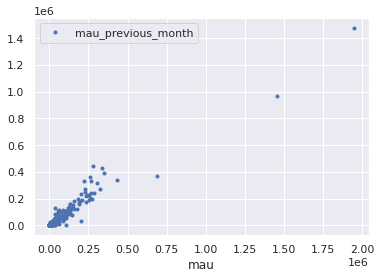

In [802]:
df.plot(x='mau', y='mau_previous_month', ls='', marker='.')

<AxesSubplot:xlabel='mau'>

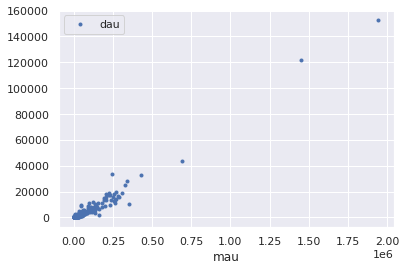

In [803]:
df.plot(x='mau', y='dau', ls='', marker='.')

<AxesSubplot:xlabel='mau'>

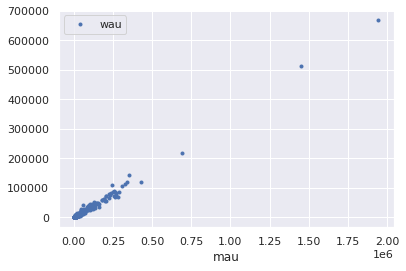

In [804]:
df.plot(x='mau', y='wau', ls='', marker='.')

<AxesSubplot:xlabel='mau'>

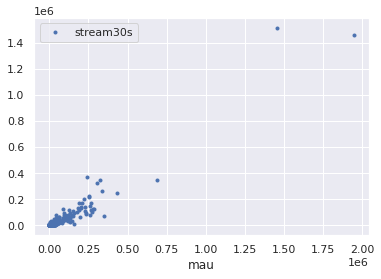

In [805]:
df.plot(x='mau', y='stream30s', ls='', marker='.')

<AxesSubplot:xlabel='stream30s'>

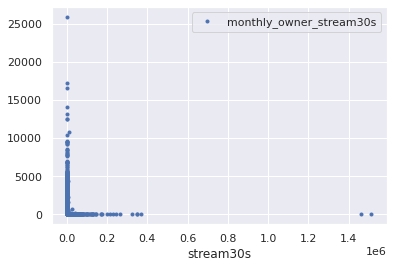

In [809]:
df.plot(x='stream30s', y='monthly_owner_stream30s', ls='', marker='.')

<AxesSubplot:xlabel='stream30s'>

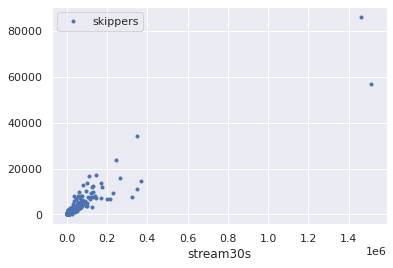

In [810]:
df.plot(x='stream30s', y='skippers', ls='', marker='.')

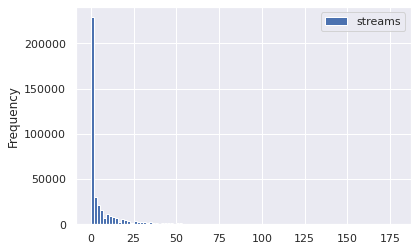

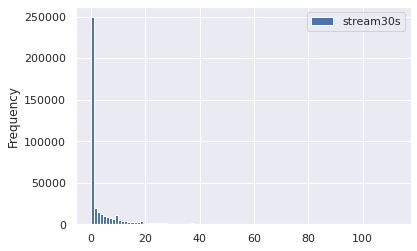

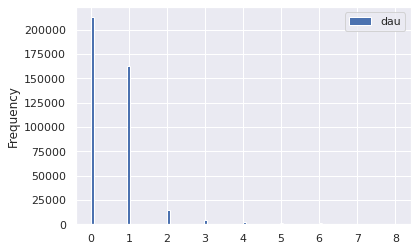

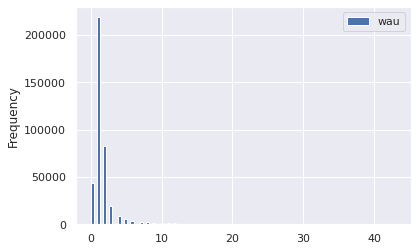

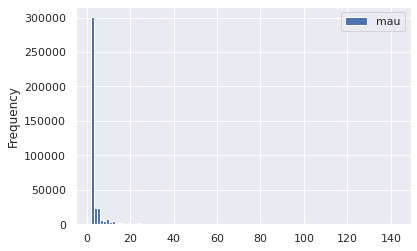

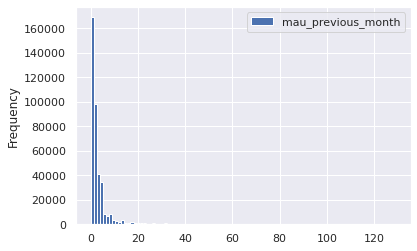

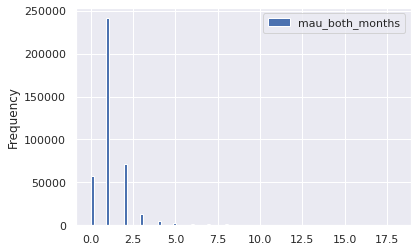

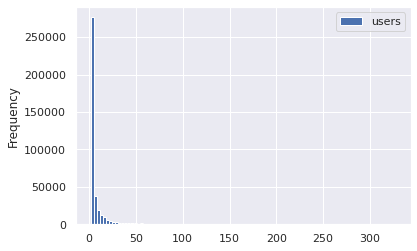

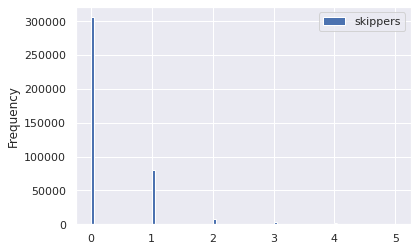

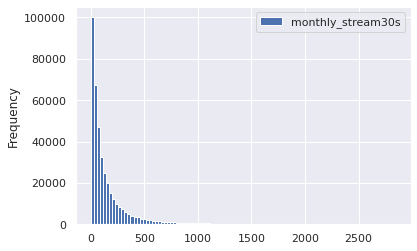

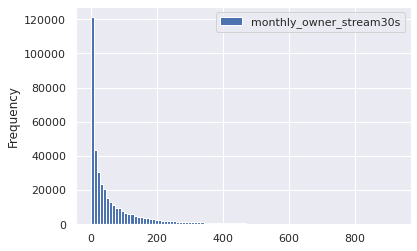

In [14]:
quant = 0.99
for target in targets:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    y.plot(kind='hist', y=target, bins=100)

removed items: 1212


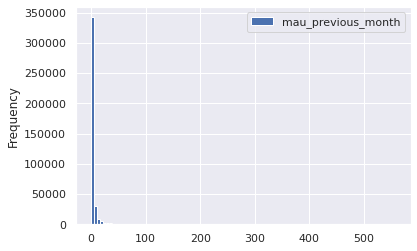

removed items: 1216


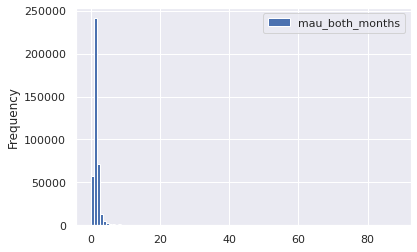

removed items: 1211


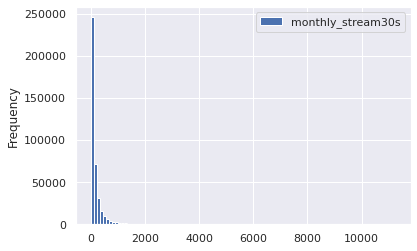

removed items: 1211


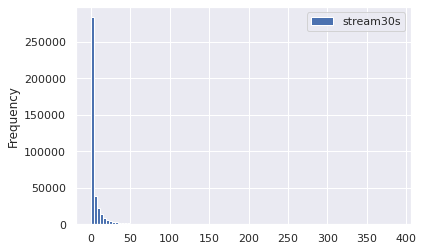

In [15]:
quant = 0.997
for target in sub_targets:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100)
    plt.show()

In [16]:
df[sub_targets].describe()

,mau_previous_month,mau_both_months,monthly_stream30s,stream30s
count,4.033660e+05,403366.000000,4.033660e+05,4.033660e+05
mean,5.819009e+01,12.937065,1.260489e+03,4.283333e+01
std,3.827248e+03,1240.912979,1.062463e+05,3.772412e+03
min,0.000000e+00,0.000000,2.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000,3.100000e+01,0.000000e+00
50%,2.000000e+00,1.000000,7.900000e+01,0.000000e+00
75%,3.000000e+00,2.000000,1.930000e+02,5.000000e+00
max,1.478684e+06,578391.000000,4.249733e+07,1.513237e+06


## Independent Variable

In [17]:
features

['n_albums',
 'n_artists',
 'mood_1',
 'n_tracks',
 'mood_3',
 'genre_1',
 'genre_2',
 'genre_3',
 'tokens',
 'owner_country',
 'n_local_tracks',
 'mood_2']

In [18]:
df[features].head()

,n_albums,n_artists,mood_1,n_tracks,mood_3,genre_1,genre_2,genre_3,tokens,owner_country,n_local_tracks,mood_2
0,7,4,Peaceful,52,Somber,Dance & House,New Age,Country & Folk,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",US,0,Romantic
1,113,112,Excited,131,Defiant,Pop,Indie Rock,Alternative,"[""good"", ""living""]",US,0,Yearning
2,36,35,Lively,43,Romantic,Latin,-,-,"[""norte\u00f1a""]",US,0,Upbeat
3,26,27,Excited,27,Defiant,Dance & House,Electronica,Pop,[],US,1,Aggressive
4,51,47,Excited,52,Yearning,Indie Rock,Alternative,Electronica,"[""cheesy"", ""pants""]",US,0,Defiant


In [19]:
con_features = list(df[features].select_dtypes('number').columns)
print(con_features)
des_features = list(df[features].select_dtypes('object').columns)
print(des_features)

['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
['mood_1', 'mood_3', 'genre_1', 'genre_2', 'genre_3', 'tokens', 'owner_country', 'mood_2']


In [20]:
df[des_features].describe()

,mood_1,mood_3,genre_1,genre_2,genre_3,tokens,owner_country,mood_2
count,403366,403366,403366,403366,403366,403366,403366,403366
unique,27,27,26,26,26,192107,1,27
top,Defiant,Energizing,Indie Rock,Alternative,Pop,[],US,Energizing
freq,81079,56450,70571,66252,78758,32568,403366,51643


we will go ahead and remove `owner_country` (1 unique), `owner`, and `tokens` (cardinal) from our feature analysis

In [21]:
id = [df.columns[0]]
targets = list(df.columns[2:11]) + ["monthly_stream30s", "monthly_owner_stream30s"]
features = set(df.columns) - set(targets) - set(id) - set(["owner_country", "owner", "tokens"])
features = list(features)

print(f"id columns: {id}")
print(f"target columns: {targets}")
print(f"feature columns: {features}")

con_features = list(df[features].select_dtypes('number').columns)
print(con_features)
des_features = ['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']
print(des_features)

id columns: ['playlist_uri']
target columns: ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users', 'skippers', 'monthly_stream30s', 'monthly_owner_stream30s']
feature columns: ['n_albums', 'mood_1', 'n_artists', 'n_tracks', 'mood_3', 'genre_1', 'genre_2', 'genre_3', 'n_local_tracks', 'mood_2']
['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']


### Discrete Features

In [22]:
df[des_features].describe()

,mood_1,mood_2,mood_3,genre_1,genre_2,genre_3
count,403366,403366,403366,403366,403366,403366
unique,27,27,27,26,26,26
top,Defiant,Energizing,Energizing,Indie Rock,Alternative,Pop
freq,81079,51643,56450,70571,66252,78758


In [23]:
df.value_counts(des_features)

mood_1    mood_2      mood_3      genre_1        genre_2        genre_3
Excited   Aggressive  Energizing  Dance & House  Electronica    Pop        4824
Defiant   Cool        Energizing  Rap            R&B            Pop        4458
          Energizing  Cool        Rap            R&B            Pop        4003
                                                 Pop            R&B        1803
                      Excited     Rap            Pop            R&B        1225
                                                                           ... 
Excited   Aggressive  Urgent      Alternative    Electronica    Metal         1
                                                 Dance & House  Pop           1
                      Upbeat      Pop            Soundtrack     -             1
                                  Indie Rock     Alternative    -             1
Yearning  Urgent      Upbeat      Soundtrack     Pop            Rap           1
Length: 138379, dtype: int64

In [24]:
df[des_features[:3]].value_counts()

mood_1    mood_2      mood_3    
Defiant   Cool        Energizing    15125
          Energizing  Cool          12278
Excited   Aggressive  Energizing     7564
Defiant   Energizing  Excited        6672
          Excited     Energizing     6179
                                    ...  
Peaceful  Urgent      Yearning          1
          Yearning    Cool              1
                      Excited           1
                      Fiery             1
Other     Urgent      Aggressive        1
Length: 9326, dtype: int64

In [25]:
df[des_features[3:]].value_counts()

genre_1        genre_2         genre_3    
Rap            R&B             Pop            15477
Indie Rock     Alternative     Rock           13102
Dance & House  Electronica     Pop            10800
Indie Rock     Alternative     Pop             9981
                               Electronica     7233
                                              ...  
New Age        Country & Folk  Rock               1
               Dance & House   R&B                1
                               Rock               1
                               Soundtrack         1
Traditional    Spoken & Audio  Religious          1
Length: 6664, dtype: int64

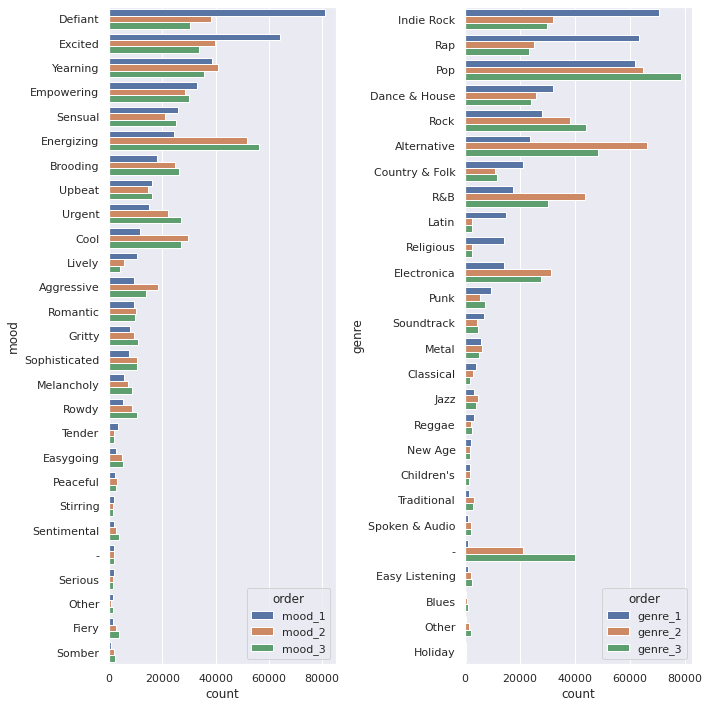

In [244]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

dff = pd.DataFrame(df[des_features[0]].value_counts()).join(
    pd.DataFrame(df[des_features[1]].value_counts())).join(
    pd.DataFrame(df[des_features[2]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['mood', 'order', 'count']
sns.barplot(data=dff, hue='order', y='mood', x='count', orient='h', ax=ax[0])

dff = pd.DataFrame(df[des_features[3]].value_counts()).join(
    pd.DataFrame(df[des_features[4]].value_counts())).join(
    pd.DataFrame(df[des_features[5]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['genre', 'order', 'count']
sns.barplot(data=dff, hue='order', y='genre', x='count', orient='h', ax=ax[1])

plt.tight_layout()

### Continuous Features

In [27]:
df[con_features].describe()

,n_albums,n_artists,n_tracks,n_local_tracks
count,403366.000000,403366.000000,403366.000000,403366.000000
mean,88.224250,83.852050,201.483432,3.084035
std,133.193118,128.152488,584.077765,40.330266
min,1.000000,1.000000,1.000000,0.000000
25%,19.000000,18.000000,38.000000,0.000000
50%,48.000000,46.000000,84.000000,0.000000
75%,106.000000,100.000000,192.000000,0.000000
max,6397.000000,5226.000000,79984.000000,9117.000000


removed items: 404


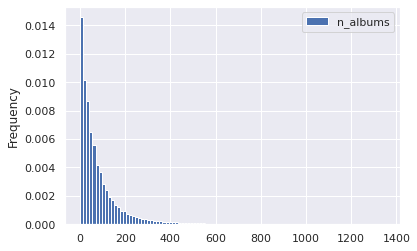

removed items: 405


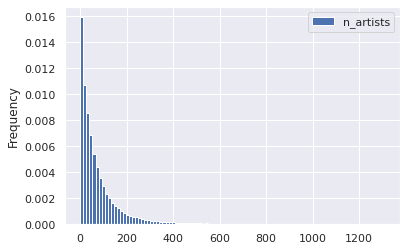

removed items: 404


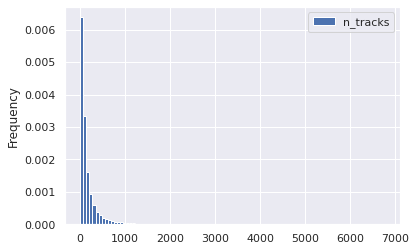

removed items: 406


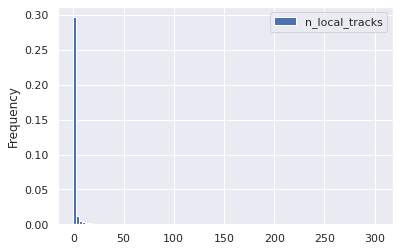

In [28]:
quant = 0.999
for target in con_features:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100, density=True)
    plt.show()

#### Bootstrapping

An example of how we will bootstrap to perform hypothesis tests later on

In [29]:
means = []
ind = con_features[0]
for i in range(100):
    boot = random.sample(
                list(
                    df.loc[
                        (df[ind] > 9) 
                        & (df[ind] < 999)
                    ][ind].values),
                k=1000)
    means.append(np.mean(boot))

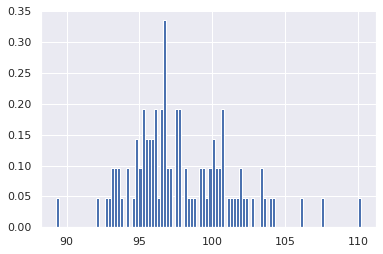

In [30]:
stuff = plt.hist(means, bins=100, density=True)

## Dependency

### Categorical Target

In [256]:
sub_targets

['mau_previous_month',
 'mau_both_months',
 'mau',
 'monthly_stream30s',
 'stream30s']

In [283]:
for target in sub_targets:
    print(f"p99 {target}: {np.quantile(df[target], 0.99)}")

p99 mau_previous_month: 130.0
p99 mau_both_months: 19.0
p99 mau: 143.0
p99 monthly_stream30s: 2843.0
p99 stream30s: 113.0


In [258]:
des_features

['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']

#### Categorical Feature

##### Moods

In [33]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
print(chidf[target].median())
moods = pd.DataFrame()
cutoff = 0.001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]
    
    for grp_label in df[ind].unique():
        # grp_label = df[ind].unique()[0]
        grp = chidf.loc[chidf[ind] == grp_label][target].values
        chi2, p, m, cTable = stats.median_test(grp, pop, correction=True)
        ratio = cTable[0]/cTable[1]
        pos = ratio[0]/ratio[1] > 1
        moods = pd.concat([moods, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])

moods.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', '+', 'reject null']
moods = moods.sort_values('p-value').reset_index(drop=True)

79.0


In [34]:
moods.loc[moods['reject null'] == True]

,feature,group,chi,p-value,cTable,+,reject null
0,genre_3,-,1725.882036,0.000000e+00,"[[16033, 205049], [24090, 198317]]",False,True
1,genre_2,-,1104.759466,3.051013e-242,"[[8216, 203517], [12990, 199849]]",False,True
2,genre_1,Latin,651.374931,1.122254e-143,"[[9000, 199027], [6012, 204339]]",True,True
3,mood_1,Energizing,611.189037,6.167816e-135,"[[10316, 203517], [14071, 199849]]",False,True
4,genre_1,Rock,315.827189,1.174487e-70,"[[12514, 201911], [15563, 201455]]",False,True
...,...,...,...,...,...,...,...
93,mood_1,Stirring,12.333846,4.448190e-04,"[[877, 200454], [1044, 202912]]",False,True
94,mood_1,Serious,12.316512,4.489689e-04,"[[778, 200454], [935, 202912]]",False,True
95,mood_2,Lively,12.161071,4.879735e-04,"[[2588, 200454], [2882, 202912]]",False,True
96,mood_2,Somber,11.618507,6.529880e-04,"[[792, 200454], [946, 202912]]",False,True


##### Chi-Square

In [35]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

##### Categorical-Categorical Conclusions

increasing `quant_value` will render additional features; as the population performance worsens, new feature/group pairs have an opportunity to increase the multiplier

Best Groups

In [36]:
chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] > 2)].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
6,genre_1,Children's,262.624693,4.596280e-59,"[[361785, 1286], [39933, 362]]",2.550270,True
11,mood_1,Other,197.598843,6.979647e-45,"[[361719, 1352], [39952, 343]]",2.296943,True
19,genre_1,Spoken & Audio,120.508309,4.896128e-28,"[[362147, 924], [40068, 227]]",2.220451,True
0,genre_1,Latin,1150.625294,3.280867e-252,"[[350782, 12289], [37572, 2723]]",2.068731,True
12,genre_1,New Age,166.484617,4.335181e-38,"[[361286, 1785], [39896, 399]]",2.024214,True


Worst Groups

In [37]:
chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] < 0.8)].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
28,mood_2,Sensual,85.309680,2.551113e-20,"[[343873, 19198], [38598, 1697]]",0.787516,True
40,genre_1,Electronica,65.249731,6.598320e-16,"[[350162, 12909], [39176, 1119]]",0.774794,True
2,genre_1,Indie Rock,366.567076,1.046303e-81,"[[298164, 64907], [34631, 5664]]",0.751315,True
13,genre_3,Electronica,163.908151,1.584260e-37,"[[337501, 25570], [38143, 2152]]",0.744684,True
21,mood_1,Brooding,109.456909,1.288759e-25,"[[346296, 16775], [38893, 1402]]",0.744152,True
48,mood_1,Gritty,49.741710,1.753777e-12,"[[355800, 7271], [39695, 600]]",0.739652,True
14,mood_1,Energizing,162.542129,3.149562e-37,"[[340541, 22530], [38438, 1857]]",0.730229,True
68,mood_3,Other,27.407286,1.648091e-07,"[[361541, 1530], [40196, 99]]",0.581994,True


We would recommend would-be superstar playlist maker construct a playlist with the following attributes:

* **Genre 1: Children's** 
    * 2.6x more likely to be in the 90th percentile
    * 4.8x more likely to be in the 99th percentile
* **Mood 1: Other** 
    * 2.3x more likely to be in the 90th percentile
    * 2.4x more likely to be in the 99th percentile

#### Continuous Feature

In [842]:
targets

['streams',
 'stream30s',
 'dau',
 'wau',
 'mau',
 'mau_previous_month',
 'mau_both_months',
 'users',
 'skippers',
 'monthly_stream30s',
 'monthly_owner_stream30s']

In [38]:
con_features

['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']

monthly_stream30s


(0.0, 200.0)

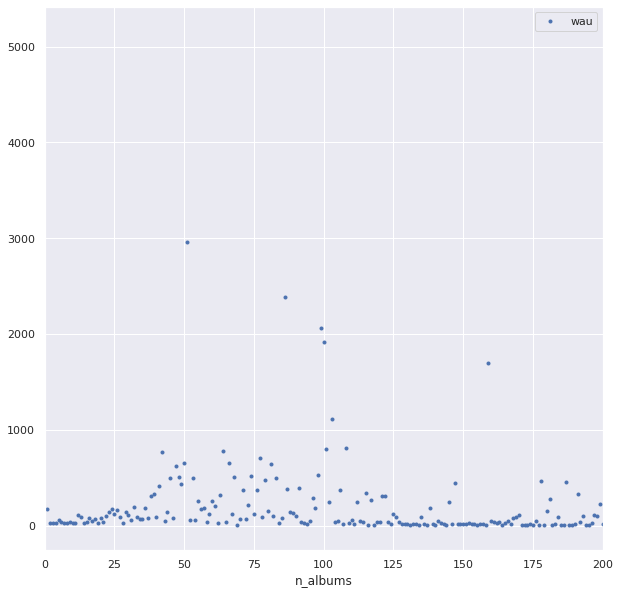

In [919]:
target = "monthly_stream30s"
print(target)
chidf[target] = df[target]
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)

fig, ax = plt.subplots(figsize=(10,10))
df.loc[df[target] > tar_value].groupby('n_albums')[['wau']].mean().plot(ls='', marker='.', ax=ax)
ax.set_xlim(0, 200)
# ax.set_ylim(0, 100)

##### t-Test

For t tests we need to deal with the long tails in the distributions along the independent variable

In [856]:
df[targets].describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,monthly_stream30s,monthly_owner_stream30s
count,4.033660e+05,4.033660e+05,403366.000000,403366.000000,4.033660e+05,4.033660e+05,403366.000000,4.033660e+05,403366.000000,4.033660e+05,403366.000000
mean,7.101375e+01,4.283333e+01,4.418265,21.784446,6.614290e+01,5.819009e+01,12.937065,1.493085e+02,2.827749,1.260489e+03,93.556621
std,6.492014e+03,3.772412e+03,358.855685,1614.650805,4.732580e+03,3.827248e+03,1240.912979,9.247484e+03,205.059728,1.062463e+05,226.250189
min,0.000000e+00,0.000000e+00,0.000000,0.000000,2.000000e+00,0.000000e+00,0.000000,2.000000e+00,0.000000,2.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,1.000000e+00,1.000000,2.000000e+00,0.000000,3.100000e+01,6.000000
50%,1.000000e+00,0.000000e+00,0.000000,1.000000,2.000000e+00,2.000000e+00,1.000000,3.000000e+00,0.000000,7.900000e+01,30.000000
75%,8.000000e+00,5.000000e+00,1.000000,2.000000,4.000000e+00,3.000000e+00,2.000000,7.000000e+00,0.000000,1.930000e+02,96.000000
max,2.629715e+06,1.513237e+06,152929.000000,669966.000000,1.944150e+06,1.478684e+06,578391.000000,3.455406e+06,86162.000000,4.249733e+07,25904.000000


In [857]:
df.loc[df['owner'] != 'spotify'][targets].describe()

,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,monthly_stream30s,monthly_owner_stream30s
count,402967.000000,402967.000000,402967.000000,402967.000000,402967.000000,402967.000000,402967.000000,402967.000000,402967.000000,4.029670e+05,402967.000000
mean,20.968960,11.990945,1.232421,5.275308,14.860487,13.483665,3.029327,32.824100,0.728640,3.543268e+02,93.647783
std,766.262668,404.190477,41.227771,185.706612,504.704081,548.731437,129.629183,1157.601711,27.054367,1.093559e+04,226.343585
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.000000e+00,0.000000
25%,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,3.100000e+01,6.000000
50%,1.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000,3.000000,0.000000,7.900000e+01,30.000000
75%,8.000000,5.000000,1.000000,2.000000,4.000000,3.000000,2.000000,7.000000,0.000000,1.930000e+02,96.000000
max,293283.000000,173753.000000,18290.000000,71891.000000,206756.000000,190026.000000,59049.000000,439699.000000,11755.000000,5.098585e+06,25904.000000


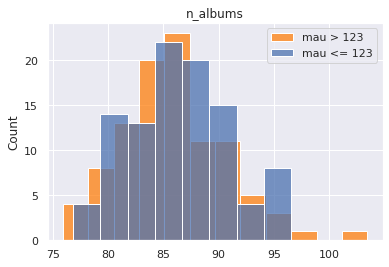

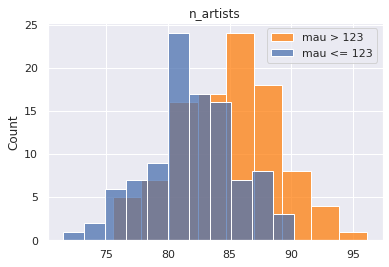

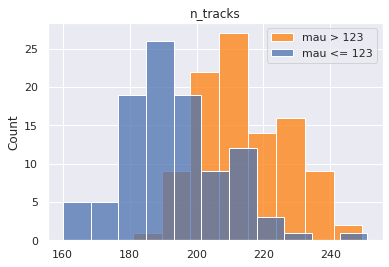

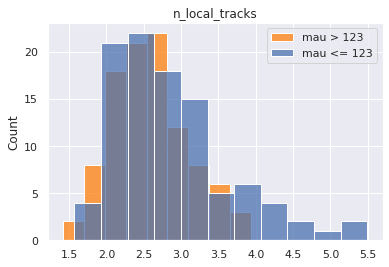

In [903]:
chidf = pd.DataFrame()
target = "mau"
chidf[target] = df[target]
quant_value = 0.99
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} > {tar_value:.0f}")
    sns.histplot(b, label=f"{target} <= {tar_value:.0f}")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

In [904]:
welchsum

,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,n_tracks,10.277868,4.444906e-20,214.33164,193.07872,True
1,n_artists,5.367785,2.238566e-07,84.92819,81.98974,True
2,n_local_tracks,-2.602519,1.006900e-02,2.59716,2.84386,False
3,n_albums,-0.827392,4.090126e-01,85.92611,86.46785,False


Let's perform the same test again this time let's say we're only interested in playlists with at least 10 tracks and fewer than 1000 tracks

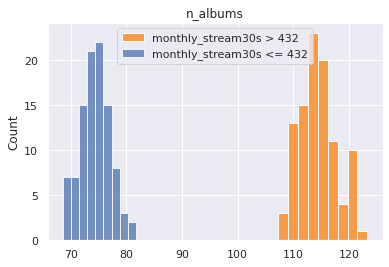

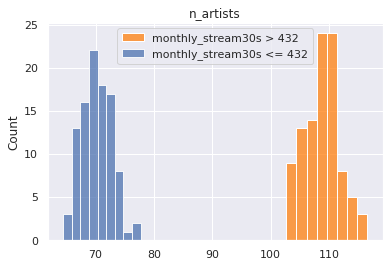

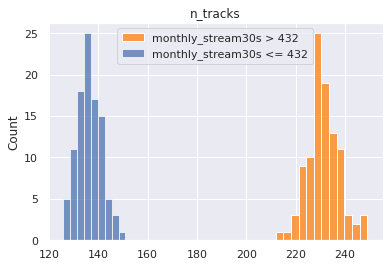

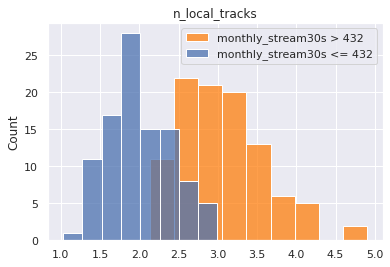

In [41]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
chidf['n_tracks'] = df['n_tracks']
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                            & (chidf['n_tracks'] > 9)
                            & (chidf['n_tracks'] < 999)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                            & (chidf['n_tracks'] > 9)
                            & (chidf['n_tracks'] < 999)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} > {tar_value:.0f}")
    sns.histplot(b, label=f"{target} <= {tar_value:.0f}")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

In [42]:
welchsum

,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,n_tracks,115.613349,3.417496e-174,231.30575,136.10481,True
1,n_artists,97.323391,2.230656e-167,108.74091,70.18516,True
2,n_albums,94.393421,2.063549e-160,114.38747,74.44801,True
3,n_local_tracks,15.122963,4.889333e-34,3.04746,1.99517,True


##### Categorical-Continuous Conclusions

Our conclusions are the same. There is a clear delineation between number of tracks, albums, and artists for popular and unpopular playlists

#### Putting it All Together

In [213]:
sub_targets

['mau_previous_month', 'mau_both_months', 'monthly_stream30s', 'stream30s']

In [311]:
des_features

['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']

In [292]:
master = pd.DataFrame()
for target in sub_targets:
    # target = sub_targets[0]
    for quant_value in [0.9, 0.99]:
        # quant_value = 0.90
        chidf = pd.DataFrame()
        chidf[target] = df[target]
        tar_value = np.quantile(chidf[target], quant_value)
        chidf[target] = chidf[target] > tar_value
        chisum = pd.DataFrame()
        cutoff = 0.0001
        pop = chidf[target].values

        for ind in des_features:
            # ind = des_features[0]
            chidf[ind] = df[ind]

            for grp_label in df[ind].unique():
            # grp_label = df[ind].unique()[0]
                try:
                    cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
                    chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
                    ratio = cTable[1]/cTable[0]
                    pos = ratio[1]/ratio[0]
                    chisum = pd.concat([chisum, pd.DataFrame([[target, quant_value, tar_value, ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
                except:
                    pass

        chisum.columns = ['target', 'upper q', 'upper q value', 'feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
        chisum = chisum.sort_values('p-value').reset_index(drop=True)
        chisum = chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] > 2)].sort_values('multiplier', ascending=False)
        master = pd.concat((master, chisum))
    
master

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null
2,mau_previous_month,0.90,9.0,genre_1,Latin,5590.525321,0.000000e+00,"[[355002, 11016], [33352, 3996]]",3.861095,True
18,mau_previous_month,0.90,9.0,genre_1,Children's,434.974313,1.343518e-96,"[[364768, 1250], [36950, 398]]",3.143224,True
1,mau_previous_month,0.90,9.0,mood_1,Lively,2312.708732,0.000000e+00,"[[358030, 7988], [34990, 2358]]",3.020517,True
22,mau_previous_month,0.90,9.0,genre_1,Traditional,357.345743,1.065483e-79,"[[364829, 1189], [36989, 359]]",2.978032,True
7,mau_previous_month,0.90,9.0,genre_2,Jazz,1046.212802,1.619916e-229,"[[362333, 3685], [36262, 1086]]",2.944750,True
...,...,...,...,...,...,...,...,...,...,...
36,stream30s,0.99,113.0,genre_2,Easy Listening,26.570340,2.541152e-07,"[[397291, 2078], [3952, 45]]",2.177002,True
29,stream30s,0.99,113.0,genre_2,Traditional,39.102302,4.021695e-10,"[[396243, 3126], [3930, 67]]",2.161001,True
24,stream30s,0.99,113.0,genre_3,Jazz,46.586071,8.768129e-12,"[[395431, 3938], [3914, 83]]",2.129376,True
22,stream30s,0.99,113.0,mood_2,Easygoing,48.122685,4.003676e-12,"[[394690, 4679], [3902, 95]]",2.053711,True


In [293]:
master['group'].value_counts()

-                 22
Romantic          19
Lively            17
Traditional       16
Children's        16
Jazz              14
Latin             12
Serious            8
Easy Listening     8
Soundtrack         8
Other              7
New Age            7
Holiday            6
Peaceful           6
Spoken & Audio     4
Fiery              3
Tender             3
Easygoing          3
Sophisticated      2
Somber             1
Name: group, dtype: int64

In [313]:
master.loc[master['upper q'] == 0.90]['group'].value_counts()

-                 12
Lively             7
Traditional        7
Children's         7
Jazz               7
Latin              7
Romantic           6
Other              5
Serious            5
Holiday            5
Easy Listening     4
Soundtrack         4
Spoken & Audio     3
Fiery              3
Sophisticated      2
New Age            1
Tender             1
Name: group, dtype: int64

In [306]:
sort_key = {i: j for i,j in zip(master['group'].value_counts().index.values, range(master['group'].nunique()))}
master['rank'] = master['group'].apply(lambda x: sort_key[x])
master.sort_values('rank', inplace=True)
# master.drop('rank', axis=1, inplace=True)
master.loc[master['group'] != '-'][:20]

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
7,monthly_stream30s,0.99,2843.0,mood_2,Romantic,146.934024,8.112487e-34,"[[389339, 9994], [3810, 223]]",2.280176,True,1
6,stream30s,0.99,113.0,mood_2,Romantic,148.026986,4.679851e-34,"[[389374, 9995], [3775, 222]]",2.290974,True,1
4,monthly_stream30s,0.99,2843.0,mood_1,Romantic,175.072639,5.772239e-40,"[[390131, 9202], [3812, 221]]",2.457919,True,1
2,mau,0.99,143.0,mood_1,Romantic,202.823985,5.053546e-46,"[[390156, 9193], [3787, 230]]",2.577588,True,1
1,mau,0.90,9.0,mood_2,Romantic,1531.190216,0.000000e+00,"[[355299, 8035], [37850, 2182]]",2.549159,True,1
8,mau_previous_month,0.90,9.0,mood_3,Romantic,1013.797108,1.800082e-222,"[[357949, 8069], [35525, 1823]]",2.276429,True,1
4,mau_previous_month,0.99,130.0,mood_1,Romantic,156.500834,6.579992e-36,"[[390127, 9209], [3816, 214]]",2.375740,True,1
8,mau,0.90,9.0,mood_3,Romantic,1170.355016,1.690629e-256,"[[355429, 7905], [38045, 1987]]",2.348287,True,1
6,mau,0.99,143.0,mood_2,Romantic,105.450504,9.729814e-25,"[[389336, 10013], [3813, 204]]",2.080289,True,1
5,mau_previous_month,0.99,130.0,mood_3,Romantic,112.605179,2.633191e-26,"[[389647, 9689], [3827, 203]]",2.133192,True,1


In [314]:
sub_targets

['mau_previous_month',
 'mau_both_months',
 'mau',
 'monthly_stream30s',
 'stream30s']

In [315]:
master.head()

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
12,stream30s,0.99,113.0,mood_3,-,125.854082,3.309444e-29,"[[397434, 1935], [3927, 70]]",3.661181,True,0
11,monthly_stream30s,0.99,2843.0,mood_2,-,109.163417,1.494430e-25,"[[397529, 1804], [3969, 64]]",3.553294,True,0
67,mau_previous_month,0.90,9.0,genre_1,-,95.863487,1.230846e-22,"[[365249, 769], [37173, 175]]",2.236007,True,0
10,monthly_stream30s,0.99,2843.0,mood_1,-,112.668942,2.549855e-26,"[[397605, 1728], [3970, 63]]",3.651389,True,0
7,stream30s,0.99,113.0,mood_1,-,141.501726,1.249779e-32,"[[397646, 1723], [3929, 68]]",3.994277,True,0


In [317]:
master.loc[master['feature'].str.contains('genre')].groupby('group')[['multiplier', 'rank']].mean().sort_values('multiplier', ascending=False)

,multiplier,rank
group,,
Tender,3.033890,16.0
-,2.935235,0.0
Peaceful,2.564297,13.0
Other,2.494292,10.0
Lively,2.364492,2.0
Romantic,2.318001,1.0
Fiery,2.244027,15.0
Somber,2.194114,19.0
Serious,2.190306,7.0


In [302]:
master['rank'] = master['group'].apply(lambda x: sort_key[x])
master.groupby('group')[['multiplier', 'rank']].mean().sort_values('multiplier', ascending=False)

,multiplier,rank
group,,
-,3.049100,0.0
Tender,3.033890,16.0
Latin,3.001282,6.0
Children's,2.871261,4.0
Holiday,2.836528,12.0
New Age,2.754796,11.0
Spoken & Audio,2.610393,14.0
Peaceful,2.564297,13.0
Other,2.425104,10.0


In [731]:
master.to_csv("chi_square_results.csv")

mau_previous_month 0.9


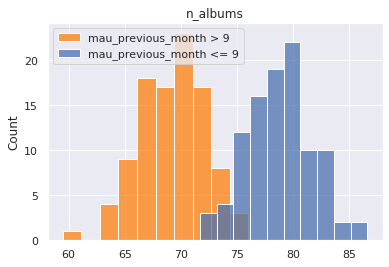

mau_previous_month 0.9


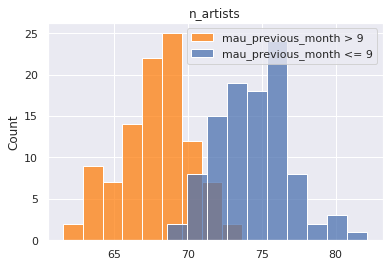

mau_previous_month 0.9


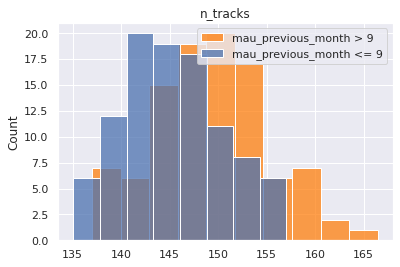

mau_previous_month 0.9


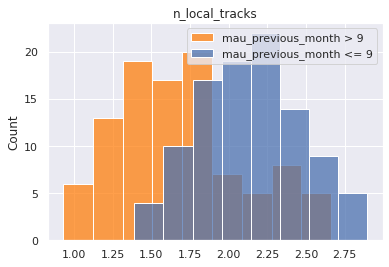

mau_previous_month 0.99


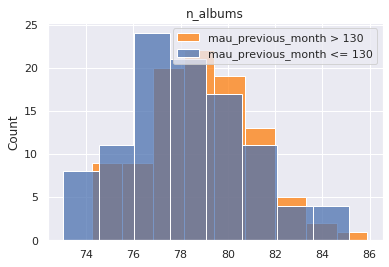

mau_previous_month 0.99


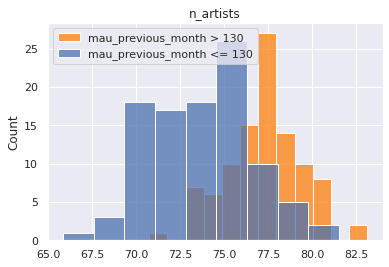

mau_previous_month 0.99


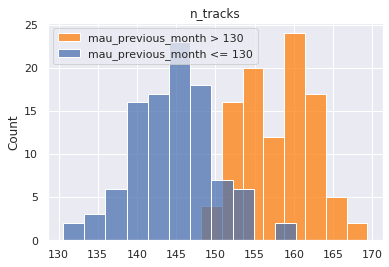

mau_previous_month 0.99


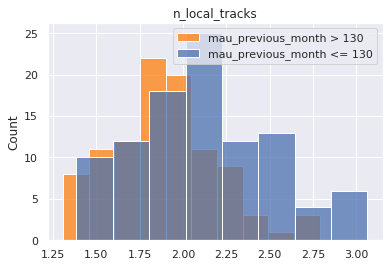

mau_both_months 0.9


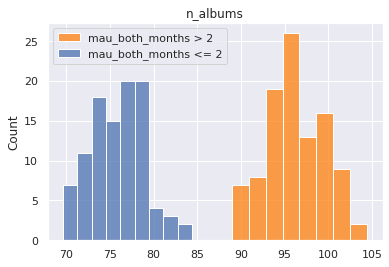

mau_both_months 0.9


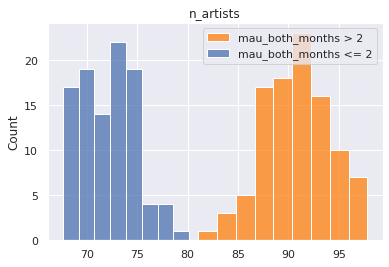

mau_both_months 0.9


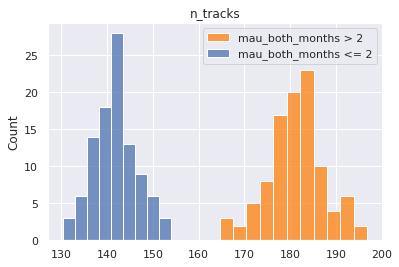

mau_both_months 0.9


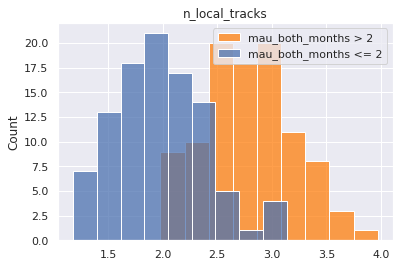

mau_both_months 0.99


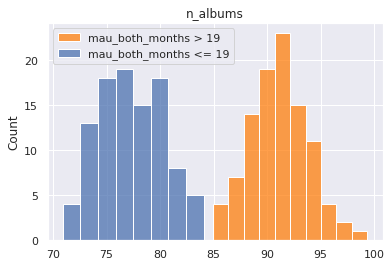

mau_both_months 0.99


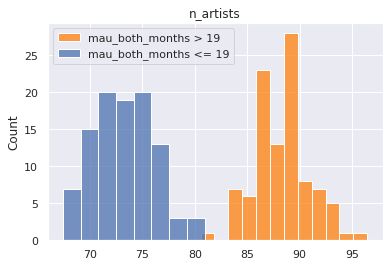

mau_both_months 0.99


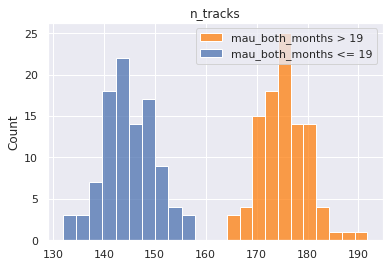

mau_both_months 0.99


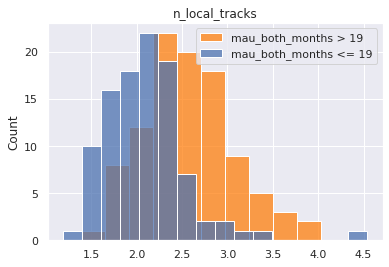

mau 0.9


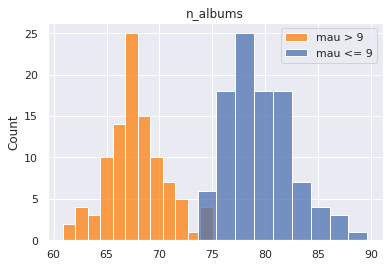

mau 0.9


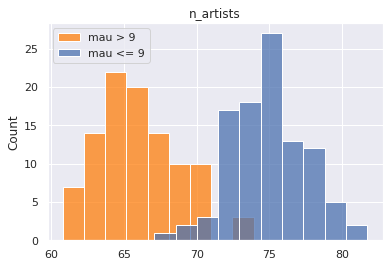

mau 0.9


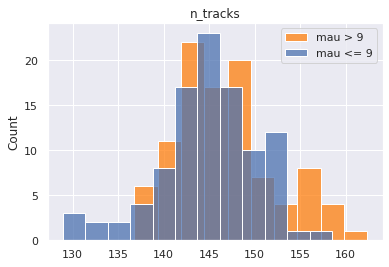

mau 0.9


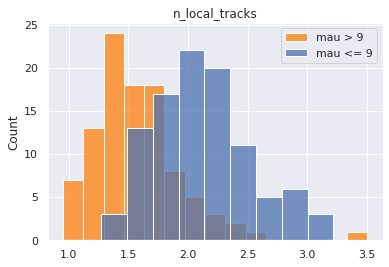

mau 0.99


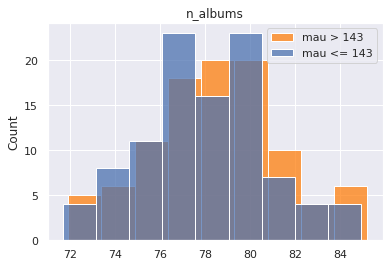

mau 0.99


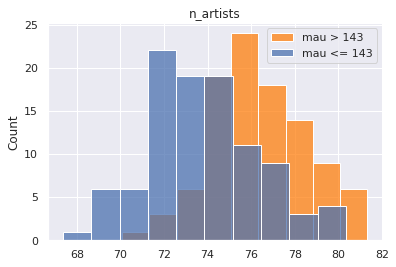

mau 0.99


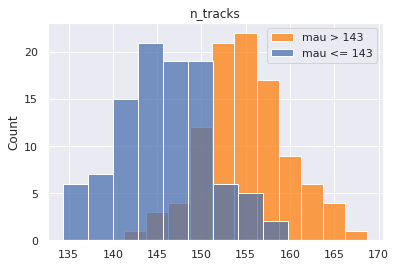

mau 0.99


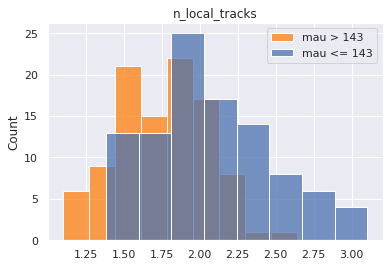

monthly_stream30s 0.9


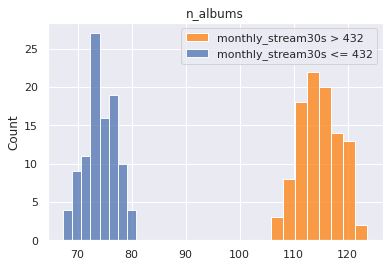

monthly_stream30s 0.9


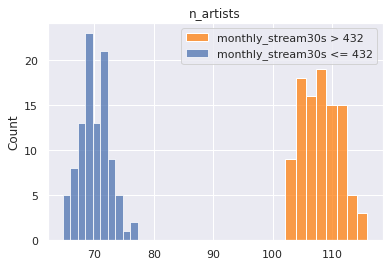

monthly_stream30s 0.9


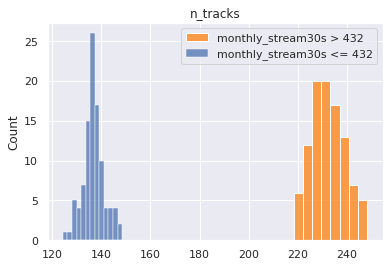

monthly_stream30s 0.9


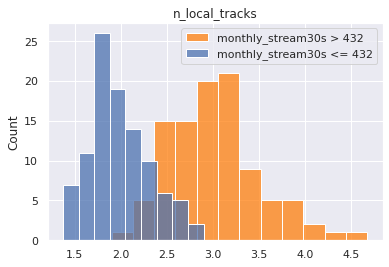

monthly_stream30s 0.99


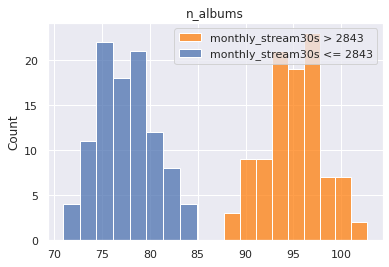

monthly_stream30s 0.99


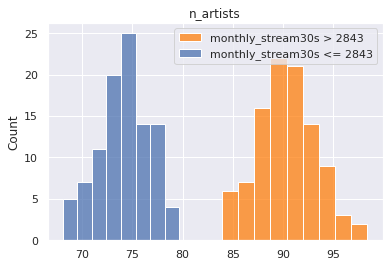

monthly_stream30s 0.99


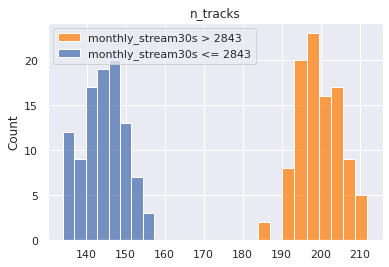

monthly_stream30s 0.99


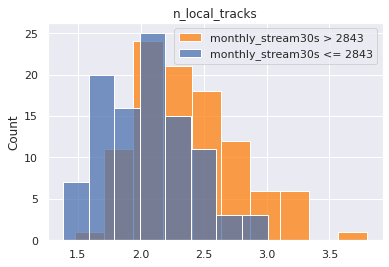

stream30s 0.9


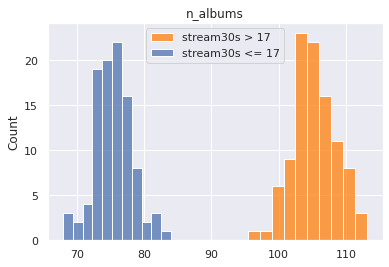

stream30s 0.9


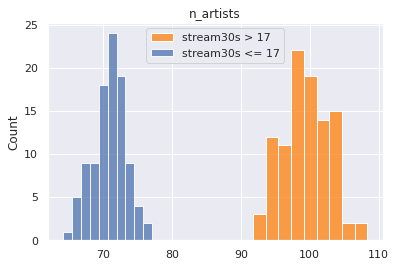

stream30s 0.9


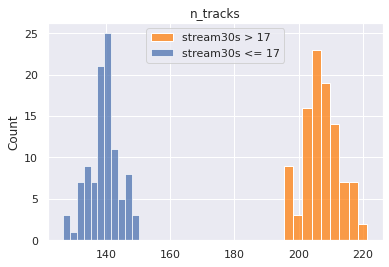

stream30s 0.9


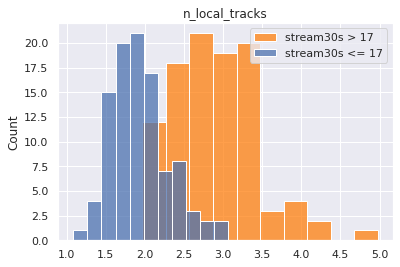

stream30s 0.99


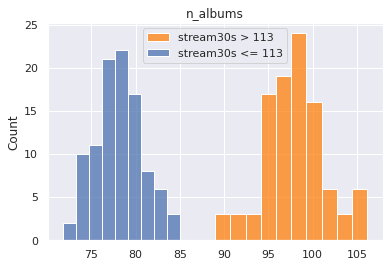

stream30s 0.99


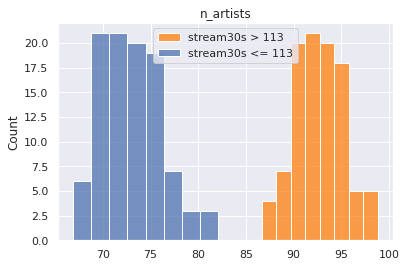

stream30s 0.99


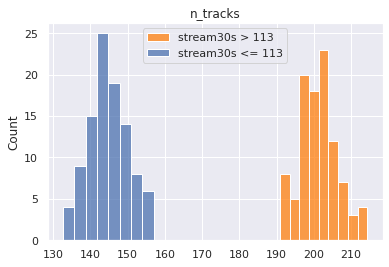

stream30s 0.99


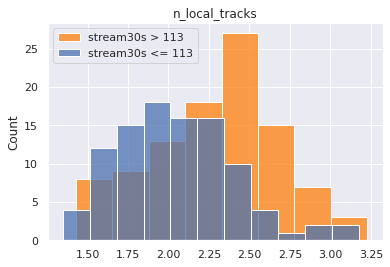

,target,quantile,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,mau_previous_month,0.90,n_albums,-23.264501,1.517148e-58,69.19828,78.75130,True
1,mau_previous_month,0.90,n_artists,-19.090166,9.131465e-47,67.78967,74.42581,True
2,mau_previous_month,0.90,n_local_tracks,-8.591563,3.210041e-15,1.68487,2.13934,True
3,mau_previous_month,0.90,n_tracks,4.900218,2.017971e-06,149.27223,145.40243,True
0,mau_previous_month,0.99,n_tracks,19.149805,1.101097e-46,157.92259,144.56996,True
1,mau_previous_month,0.99,n_artists,9.668152,4.508161e-18,77.26126,73.71656,True
2,mau_previous_month,0.99,n_local_tracks,-4.443426,1.514586e-05,1.89286,2.11507,True
3,mau_previous_month,0.99,n_albums,1.862787,6.399527e-02,78.89529,78.24458,False
0,mau_both_months,0.90,n_tracks,49.521659,1.017659e-108,181.22258,141.77758,True
1,mau_both_months,0.90,n_albums,44.662168,7.684105e-105,96.16066,75.92092,True


In [789]:
con_master = pd.DataFrame()
for target in sub_targets:
    # target = sub_targets[2]
    for quant_value in [0.90, 0.99]:
        chidf = pd.DataFrame()
        chidf[target] = df[target]
        chidf['n_tracks'] = df['n_tracks']
        # quant_value = 0.90
        tar_value = np.quantile(chidf[target], quant_value)
        chidf[target] = chidf[target] > tar_value
        welchsum = pd.DataFrame()
        cutoff = 0.0001
        pop = chidf[target].values

        for ind in con_features:
            # ind = con_features[0]
            chidf[ind] = df[ind]

            # for grp_label in df[ind].unique():
            # try:
            a = []
            b = []
            for i in range(100):
                boot1 = random.sample(
                            list(
                                chidf.loc[
                                    (chidf[target] == True)
                                    & (chidf['n_tracks'] > 9)
                                    & (chidf['n_tracks'] < 999)
                                ][ind].values),
                            k=1000)
                boot2 = random.sample(
                            list(
                                chidf.loc[
                                    (chidf[target] == False)
                                    & (chidf['n_tracks'] > 9)
                                    & (chidf['n_tracks'] < 999)
                                ][ind].values),
                            k=1000)
                a.append(np.mean(boot1))
                b.append(np.mean(boot2))
            testt, p = stats.ttest_ind(a, b, equal_var=False)
            a_avg = np.mean(a)
            b_avg = np.mean(b)
            welchsum = pd.concat([welchsum, pd.DataFrame([[target, quant_value, ind, testt, p, a_avg, b_avg, p<cutoff]])])
            print(target, quant_value)
            sns.histplot(a, color='tab:orange', label=f"{target} > {tar_value:.0f}")
            sns.histplot(b, label=f"{target} <= {tar_value:.0f}")
            plt.title(ind)
            plt.legend()
            plt.show()
            # except:
            #     pass

        welchsum.columns = ['target', 'quantile', 'feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
        welchsum = welchsum.sort_values('p-value').reset_index(drop=True)
        con_master = pd.concat((con_master, welchsum))
con_master

In [790]:
con_master

,target,quantile,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,mau_previous_month,0.90,n_albums,-23.264501,1.517148e-58,69.19828,78.75130,True
1,mau_previous_month,0.90,n_artists,-19.090166,9.131465e-47,67.78967,74.42581,True
2,mau_previous_month,0.90,n_local_tracks,-8.591563,3.210041e-15,1.68487,2.13934,True
3,mau_previous_month,0.90,n_tracks,4.900218,2.017971e-06,149.27223,145.40243,True
0,mau_previous_month,0.99,n_tracks,19.149805,1.101097e-46,157.92259,144.56996,True
1,mau_previous_month,0.99,n_artists,9.668152,4.508161e-18,77.26126,73.71656,True
2,mau_previous_month,0.99,n_local_tracks,-4.443426,1.514586e-05,1.89286,2.11507,True
3,mau_previous_month,0.99,n_albums,1.862787,6.399527e-02,78.89529,78.24458,False
0,mau_both_months,0.90,n_tracks,49.521659,1.017659e-108,181.22258,141.77758,True
1,mau_both_months,0.90,n_albums,44.662168,7.684105e-105,96.16066,75.92092,True


In [732]:
con_master.to_csv("t_test_results.csv")

#### Models (Multi-Feature Analysis)

##### Deciles - Random Forest

In [331]:
sub_targets

['mau_previous_month',
 'mau_both_months',
 'mau',
 'monthly_stream30s',
 'stream30s']

In [794]:
target = sub_targets[-2]

In [795]:
y = df[target].values
labels = y.copy()
names = []
for idx, quant in zip(range(11), np.linspace(0, 1, num=11)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

In [796]:
names

['less than 13 listens',
 '13 < listens <= 24',
 '24 < listens <= 38',
 '38 < listens <= 55',
 '55 < listens <= 79',
 '79 < listens <= 111',
 '111 < listens <= 159',
 '159 < listens <= 240',
 '240 < listens <= 432',
 '432 < listens <= 42497334']

In [797]:
X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [798]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [799]:
y_hat_test = model.predict(X_test)
print(f"Train Acc: {accuracy_score(y_test, y_hat_test):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

Train Acc: 0.14
Test Acc: 0.14


In [800]:
print(classification_report(y_test, y_hat_test, zero_division=0))

              precision    recall  f1-score   support

           1       0.19      0.26      0.22      8363
           2       0.13      0.13      0.13      7866
           3       0.13      0.12      0.13      8173
           4       0.10      0.09      0.10      7773
           5       0.11      0.10      0.10      8252
           6       0.11      0.09      0.10      7976
           7       0.11      0.10      0.10      8018
           8       0.12      0.10      0.11      8185
           9       0.14      0.14      0.14      8009
          10       0.20      0.26      0.23      8059

    accuracy                           0.14     80674
   macro avg       0.13      0.14      0.14     80674
weighted avg       0.13      0.14      0.14     80674



<AxesSubplot:>

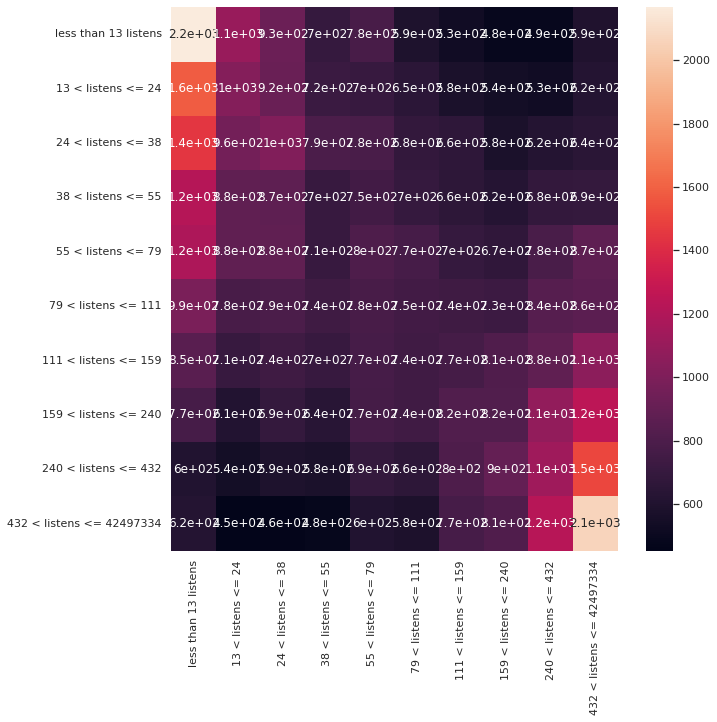

In [801]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax, xticklabels=names, yticklabels=names)

In [368]:
# grab feature importances
imp = model.feature_importances_

# their std
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# build feature names
feature_names = con_features + list(enc.get_feature_names_out())

# create new dataframe
feat = pd.DataFrame([feature_names, imp, std]).T
feat.columns = ['feature', 'importance', 'std']
feat = feat.sort_values('importance', ascending=False)
feat = feat.reset_index(drop=True)
feat.dropna(inplace=True)
feat.head(20)

,feature,importance,std
0,n_tracks,0.152852,0.006907
1,n_albums,0.135581,0.007403
2,n_artists,0.133666,0.007421
3,n_local_tracks,0.038311,0.005365
4,genre_2_Pop,0.011607,0.000991
5,genre_3_Pop,0.01145,0.003792
6,genre_3_Alternative,0.010917,0.002062
7,genre_3_Rock,0.009709,0.002517
8,mood_3_Excited,0.009644,0.000618
9,mood_2_Excited,0.009271,0.000782


##### Quartiles - Random Forest

Train Acc: 0.99
Test Acc: 0.33
              precision    recall  f1-score   support

           1       0.37      0.43      0.40     20461
           2       0.27      0.23      0.25     19966
           3       0.27      0.23      0.25     20082
           4       0.39      0.44      0.41     20165

    accuracy                           0.33     80674
   macro avg       0.33      0.33      0.33     80674
weighted avg       0.33      0.33      0.33     80674



<AxesSubplot:>

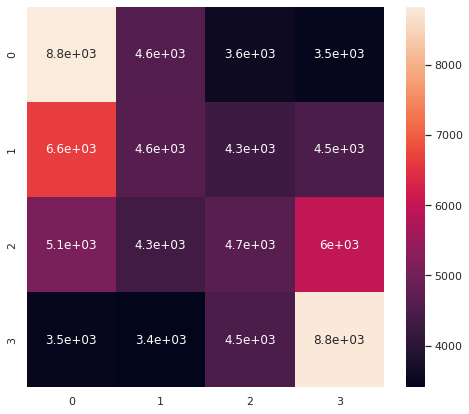

In [112]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
lim = 5
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train)

### Asses Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

##### Binary, 90th Percentile, Random Forest

In [484]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 5
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        weights[(y > np.quantile(y, prev))
              &(y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
        
    prev = quant
y = labels

In [372]:
### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, weights, random_state=42, train_size=0.8)


### Strateification Code

# strat_y0_idx = np.array(random.sample(list(np.argwhere(y_train==3).reshape(-1)), np.unique(y_train, return_counts=True)[1][1]))
# strat_y1_idx = np.argwhere(y_train==4).reshape(-1)
# strat_idx = np.hstack((strat_y0_idx, strat_y1_idx))
# X_train = X_train[strat_idx]
# y_train = y_train[strat_idx]

/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Acc: 0.76
Test Acc: 0.76
              precision    recall  f1-score   support

           3       0.76      0.98      0.86     60509
           4       0.58      0.08      0.13     20165

    accuracy                           0.76     80674
   macro avg       0.67      0.53      0.50     80674
weighted avg       0.72      0.76      0.68     80674



<AxesSubplot:>

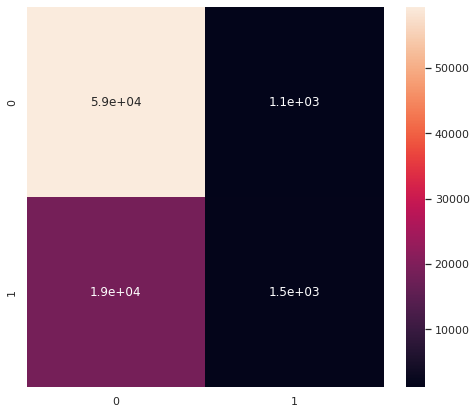

In [373]:
### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train)

### Assess Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

##### Forward Selection Model

In [674]:
### y
print(target)
y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = 0
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              & (labels <= np.quantile(y, quant))] = 1
        weights[(y > np.quantile(y, prev))
              & (y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

#### X

X = df[des_features + con_features]

enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((np.ones((X_con.shape[0], 1)), X_con, X_cat))
feature_names = ['intercept'] + con_features + list(enc.get_feature_names_out())

data = pd.DataFrame(X, columns=feature_names)
print(names)

monthly_stream30s
['less than 432 listens', '432 < listens <= 42497334']


In [669]:
def add_feature(feature_names, basemodel, data, y, r2max=0, model='linear', disp=0):
    feature_max = None
    bestsum = None
    newmodel = None
    for feature in feature_names:
        basemodel[feature] = data[feature]
        X2 = basemodel.values
        est = Logit(y, X2)
        est2 = est.fit(disp=0)
        summ = est2.summary()
        score = float(str(pd.DataFrame(summ.tables[0]).loc[3, 3]))
        if (score > r2max) and not (est2.pvalues > cutoff).any():
            r2max = score
            feature_max = feature
            bestsum = est2.summary()
            newmodel = basemodel.copy()
            if disp == 1:
                print(f"new r2max, {feature_max}, {r2max}")
        basemodel.drop(labels = feature, axis = 1, inplace = True)
    return r2max, feature_max, bestsum, newmodel

In [670]:
candidates = feature_names.copy()
basemodel = pd.DataFrame()
r2max = 0

In [650]:
with open("canidates.txt", "w+") as f:
    file_data = f.read()
    for i in candidates:
        f.write(f"{i}\n")

In [680]:
basemodel.to_csv("basemodel.csv")

In [678]:
with open("canidates.txt", "r") as f:
    # file_data = f.read()
    new = []
    for line in f:
        current_place = line[:-1]
        new.append(current_place)

In [683]:
new = pd.read_csv("basemodel.csv", index_col=0)

In [700]:
with open("fwd_selection_results.txt", "r+") as f:
    for line in f:
        pass
    lastline = line[:-1]
    stuff = lastline.split(", ")
    new = float(stuff[-1])


In [701]:
new

0.04052

In [675]:
while True:
    newr2max, feature_max, bestsum, newmodel = add_feature(
        feature_names=candidates, 
        basemodel=basemodel, 
        data=data, 
        y=y,
        r2max=r2max)    
    if newr2max > r2max:
        r2max = newr2max
        print(f"new r2max, {feature_max}, {r2max}")
        with open("fwd_selection_results.txt", "a+") as f:
            file_data = f.read()
            f.write(f"new r2max, {feature_max}, {r2max}\n")
        candidates.remove(feature_max)
        with open("canidates.txt", "w+") as f:
            file_data = f.read()
            for i in candidates:
                f.write(f"{i}\n")
        basemodel = newmodel
        basemodel.to_csv("basemodel.csv")
        continue
    else:
        break

new r2max, n_albums, 0.02614
new r2max, genre_1_Latin, 0.03093
new r2max, genre_1_Indie Rock, 0.03274
new r2max, genre_1_Rap, 0.03431
new r2max, genre_1_Dance & House, 0.03568
new r2max, genre_1_Rock, 0.03674
new r2max, mood_1_Energizing, 0.03772
new r2max, genre_1_Children's, 0.03863
new r2max, mood_1_Tender, 0.03931
new r2max, mood_1_Other, 0.03995
new r2max, n_tracks, 0.04052


KeyboardInterrupt: 

In [676]:
candidates

['n_artists',
 'n_local_tracks',
 'mood_1_-',
 'mood_1_Aggressive',
 'mood_1_Brooding',
 'mood_1_Cool',
 'mood_1_Defiant',
 'mood_1_Easygoing',
 'mood_1_Empowering',
 'mood_1_Excited',
 'mood_1_Fiery',
 'mood_1_Gritty',
 'mood_1_Lively',
 'mood_1_Melancholy',
 'mood_1_Peaceful',
 'mood_1_Romantic',
 'mood_1_Rowdy',
 'mood_1_Sensual',
 'mood_1_Sentimental',
 'mood_1_Serious',
 'mood_1_Somber',
 'mood_1_Sophisticated',
 'mood_1_Stirring',
 'mood_1_Upbeat',
 'mood_1_Urgent',
 'mood_1_Yearning',
 'mood_2_-',
 'mood_2_Aggressive',
 'mood_2_Brooding',
 'mood_2_Cool',
 'mood_2_Defiant',
 'mood_2_Easygoing',
 'mood_2_Empowering',
 'mood_2_Energizing',
 'mood_2_Excited',
 'mood_2_Fiery',
 'mood_2_Gritty',
 'mood_2_Lively',
 'mood_2_Melancholy',
 'mood_2_Other',
 'mood_2_Peaceful',
 'mood_2_Romantic',
 'mood_2_Rowdy',
 'mood_2_Sensual',
 'mood_2_Sentimental',
 'mood_2_Serious',
 'mood_2_Somber',
 'mood_2_Sophisticated',
 'mood_2_Stirring',
 'mood_2_Tender',
 'mood_2_Upbeat',
 'mood_2_Urgent',
 '

In [677]:
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
res_df

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-2.0979,0.008,-273.128,0.000,-2.113,-2.083
n_albums,0.3430,0.006,61.214,0.000,0.332,0.354
genre_1_Latin,0.6929,0.023,30.536,0.000,0.648,0.737
genre_1_Indie Rock,-0.4654,0.016,-28.755,0.000,-0.497,-0.434
genre_1_Rap,-0.3804,0.016,-23.163,0.000,-0.413,-0.348
genre_1_Dance & House,-0.3978,0.022,-18.022,0.000,-0.441,-0.355
genre_1_Rock,-0.3562,0.023,-15.423,0.000,-0.402,-0.311
mood_1_Energizing,-0.3623,0.025,-14.323,0.000,-0.412,-0.313
genre_1_Children's,0.9479,0.061,15.652,0.000,0.829,1.067
mood_1_Tender,0.6629,0.047,14.006,0.000,0.570,0.756


##### Binary, 99th Percentile

Train Acc: 1.00
Test Acc: 0.90
              precision    recall  f1-score   support

           9       0.90      0.99      0.94     72615
          10       0.27      0.03      0.05      8059

    accuracy                           0.90     80674
   macro avg       0.59      0.51      0.50     80674
weighted avg       0.84      0.90      0.86     80674



<AxesSubplot:>

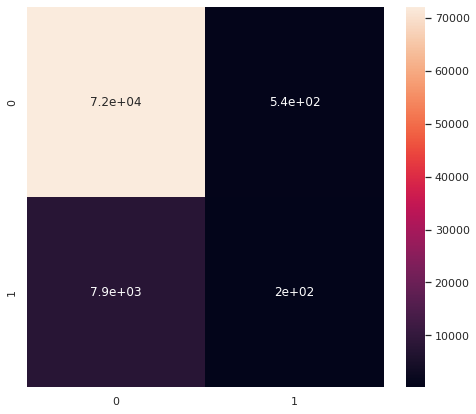

In [110]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        weights[(y > np.quantile(y, prev))
              &(y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
        
    prev = quant
y = labels

### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X, y, weights, random_state=42, train_size=0.8)

### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train, weight_train)

### Asses Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

## Other Metrics

* 30s listens/tot listens (listen conversions) _also like a bounce rate_
* Users both months/users prev month (user conversions)
    * combine with mau > mau_previous_month
* Best small time performers (less than X total monthly listens + high conversion)
* Best new user playlist (owner has only 1 popular playlist)

### Listen and User Conversions, MAU Growing

In [975]:
df['listen_conversions'] = df['stream30s'] / df['streams']
df['listen_conversions'].fillna(value=0, inplace=True)

df['user_retention'] = df['mau_both_months'] / df['mau_previous_month']
df['user_retention'].fillna(value=0, inplace=True)

df['user_conversions'] = df['mau'] / df['users']
df['user_conversions'].fillna(value=0, inplace=True)


df['mau_growing'] = df['mau'] > df['mau_previous_month']
df['mau_growth'] = df['mau'] / df['mau_previous_month']
df['mau_growth'].fillna(value=0, inplace=True)
df['mau_growth'].replace([np.inf, -np.inf], 1, inplace=True)

In [976]:
new_metrics = ['listen_conversions', 'user_conversions', 'user_retention', 'mau_growth']

In [977]:
df[new_metrics].describe()

,listen_conversions,user_conversions,user_retention,mau_growth
count,403366.000000,403366.000000,403366.000000,403366.000000
mean,0.334701,0.724072,0.571070,1.513218
std,0.399968,0.261708,0.392073,17.459669
min,0.000000,0.020348,0.000000,0.031250
25%,0.000000,0.500000,0.200000,1.000000
50%,0.000000,0.666667,0.500000,1.066667
75%,0.730769,1.000000,1.000000,2.000000
max,1.000000,1.000000,1.000000,7859.000000


<AxesSubplot:ylabel='Frequency'>

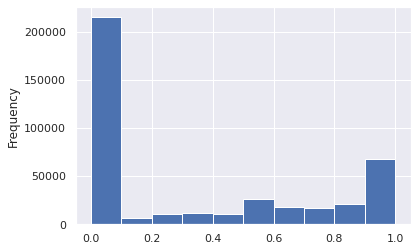

In [978]:
df['listen_conversions'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

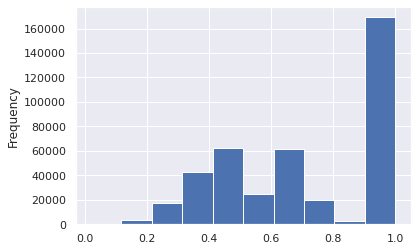

In [979]:
df['user_conversions'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

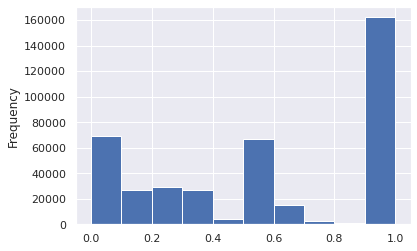

In [980]:
df['user_retention'].plot(kind='hist', bins=10)

<AxesSubplot:ylabel='Frequency'>

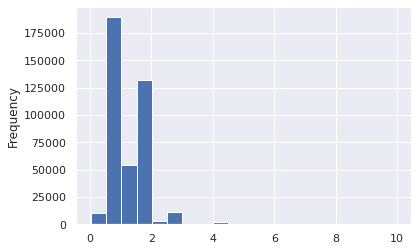

In [984]:
df.loc[df['mau_growth'] < 10]['mau_growth'].plot(kind='hist', bins=20)

<AxesSubplot:>

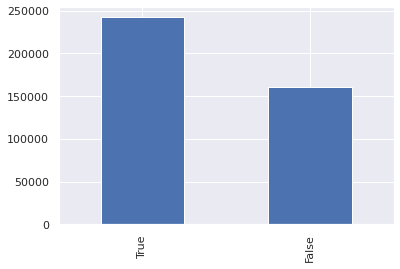

In [968]:
df['mau_growing'].value_counts().plot(kind='bar')

In [999]:
df['new_success'] = df[new_metrics].apply(lambda x: (x > 0.5) if (max(x) == 1) else (x > 1)).all(axis=1)

In [1000]:
df['new_success'].value_counts()

False    362869
True      40497
Name: new_success, dtype: int64

In [1005]:
df.loc[df['new_success'] == True]

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3,success,listen_conversions,user_retention,user_conversions,mau_growing,mau_growth,new_success
14,spotify:user:9a3580868994077be27d244788d494cd:...,9a3580868994077be27d244788d494cd,28,15,1,1,2,1,1,2,0,US,321,0,170,205,83,77,"[""sunny"", ""daze""]",Alternative,Indie Rock,Electronica,Brooding,Excited,Sensual,False,0.535714,1.0,1.000000,True,2.000000,True
18,spotify:user:7abbdbd3119687473b8f2986e73e2ad6:...,7abbdbd3119687473b8f2986e73e2ad6,9,5,1,2,2,1,1,2,0,US,373,8,1,1,18,11,[],Pop,Alternative,Indie Rock,Empowering,Excited,Urgent,False,0.555556,1.0,1.000000,True,2.000000,True
20,spotify:user:838141e861005b6a955cb389c19671a5:...,838141e861005b6a955cb389c19671a5,32,25,2,3,4,3,3,5,1,US,904,0,81,125,327,253,"[""metalcore"", ""forever""]",Punk,Metal,Rock,Defiant,Urgent,Aggressive,False,0.781250,1.0,0.800000,True,1.333333,True
36,spotify:user:2217942070bcaa5f1e651e27744b4402:...,2217942070bcaa5f1e651e27744b4402,18,17,1,2,4,3,3,5,1,US,141,1,122,131,567,0,"[""chill""]",Rap,Dance & House,Alternative,Excited,Defiant,Energizing,False,0.944444,1.0,0.800000,True,1.333333,True
59,spotify:user:dfde15dd16b4ad87a75036276b4c9f66:...,dfde15dd16b4ad87a75036276b4c9f66,5,5,1,1,2,1,1,3,0,US,84,0,73,78,254,239,"[""vegas""]",Rock,Pop,R&B,Upbeat,Excited,Empowering,False,1.000000,1.0,0.666667,True,2.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403329,spotify:user:358b83239c6a2557fbfb053330d49a41:...,358b83239c6a2557fbfb053330d49a41,4,4,1,1,3,1,1,3,0,US,33,0,28,31,271,32,"[""one"", ""dirt"", ""road""]",Country & Folk,Rock,-,Yearning,Empowering,Gritty,False,1.000000,1.0,1.000000,True,3.000000,True
403336,spotify:user:a0781a2de47beb8bd693f3022f316327:...,a0781a2de47beb8bd693f3022f316327,856,855,3,10,10,5,5,10,0,US,168,0,6,9,33747,1391,"[""evning"", ""song""]",-,-,-,-,-,-,True,0.998832,1.0,1.000000,True,2.000000,True
403338,spotify:user:06f6dd666f1bbf9148c792b87ed4d22f:...,06f6dd666f1bbf9148c792b87ed4d22f,5,4,1,1,2,1,1,2,0,US,59,0,34,46,21,9,"[""rhc""]",Religious,Pop,Alternative,Empowering,Upbeat,Brooding,False,0.800000,1.0,1.000000,True,2.000000,True
403348,spotify:user:c6af258245d55221cebedb1175f08d83:...,c6af258245d55221cebedb1175f08d83,13,11,1,1,2,1,1,2,0,US,31,0,30,29,208,206,"[""zumba"", ""val"", ""silva"", ""playlist""]",Latin,Pop,Dance & House,Aggressive,Excited,Defiant,False,0.846154,1.0,1.000000,True,2.000000,True


In [992]:
chidf = pd.DataFrame()
target = 'new_success'
chidf[target] = df[target]
# quant_value = 0.90
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

In [995]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
6,genre_1,Dance & House,231.225731,3.221322e-52,"[[334768, 28101], [36487, 4010]]",1.309267,True
2,genre_1,Indie Rock,386.328998,5.212769e-86,"[[300809, 62060], [31986, 8511]]",1.289733,True
3,mood_1,Excited,289.821405,5.438394e-65,"[[306376, 56493], [32871, 7626]]",1.258184,True
4,mood_1,Defiant,285.014998,6.064223e-64,"[[291222, 71647], [31065, 9432]]",1.234123,True
16,genre_2,Electronica,124.733558,5.820843e-29,"[[335186, 27683], [36772, 3725]]",1.226540,True
...,...,...,...,...,...,...,...
70,mood_1,Somber,30.852148,2.784538e-08,"[[361994, 875], [40456, 41]]",0.419270,True
0,genre_3,-,1404.327669,2.410008e-307,"[[324633, 38236], [38610, 1887]]",0.414947,True
1,genre_2,-,861.809401,1.968786e-189,"[[342541, 20328], [39619, 878]]",0.373430,True
24,mood_1,Other,81.806778,1.500630e-19,"[[361232, 1637], [40439, 58]]",0.316494,True


In [1001]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=True)[:20]

,feature,group,chi,p-value,cTable,multiplier,reject null
42,genre_1,Spoken & Audio,58.779116,1.764037e-14,"[[361755, 1114], [40460, 37]]",0.296965,True
24,mood_1,Other,81.806778,1.500630e-19,"[[361232, 1637], [40439, 58]]",0.316494,True
1,genre_2,-,861.809401,1.968786e-189,"[[342541, 20328], [39619, 878]]",0.373430,True
0,genre_3,-,1404.327669,2.410008e-307,"[[324633, 38236], [38610, 1887]]",0.414947,True
70,mood_1,Somber,30.852148,2.784538e-08,"[[361994, 875], [40456, 41]]",0.419270,True
73,genre_1,Easy Listening,30.613123,3.149562e-08,"[[361984, 885], [40455, 42]]",0.424642,True
40,mood_2,-,60.796108,6.330294e-15,"[[361087, 1782], [40411, 86]]",0.431224,True
43,mood_1,-,57.600397,3.211607e-14,"[[361161, 1708], [40414, 83]]",0.434269,True
37,mood_3,-,64.489845,9.703118e-16,"[[360957, 1912], [40404, 93]]",0.434536,True
48,genre_1,Children's,52.188042,5.043231e-13,"[[361298, 1571], [40420, 77]]",0.438111,True


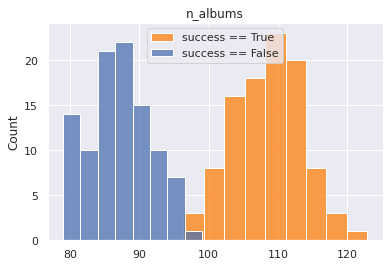

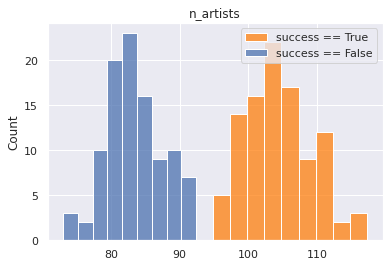

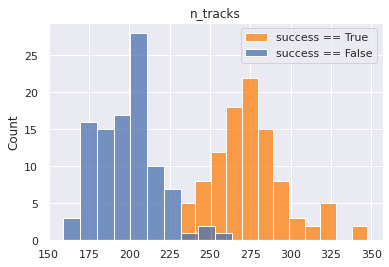

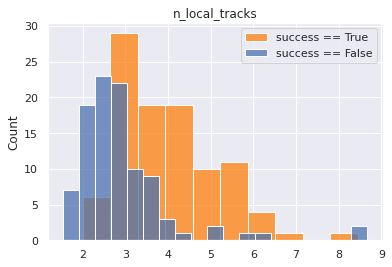

In [1009]:
chidf = pd.DataFrame()
target = "success"
chidf[target] = df[target]
# chidf.iloc[:int(chidf.shape[0]/2),:] = True
# chidf.iloc[int(chidf.shape[0]/2):,:] = False
# quant_value = 0.99
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} == True")
    sns.histplot(b, label=f"{target} == False")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

<AxesSubplot:xlabel='listen_conversions', ylabel='Count'>

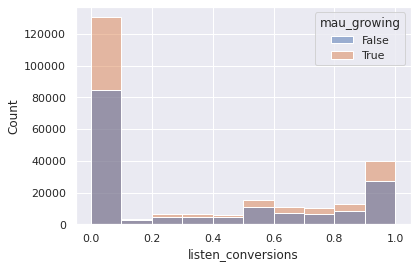

In [198]:
sns.histplot(df, x='listen_conversions', hue='mau_growing', bins=10)

<AxesSubplot:xlabel='user_conversions', ylabel='Count'>

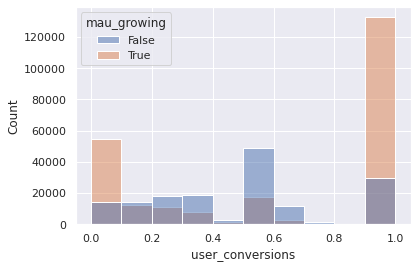

In [200]:
sns.histplot(df, x='user_conversions', hue='mau_growing', bins=10)

<AxesSubplot:xlabel='user_conversions', ylabel='Count'>

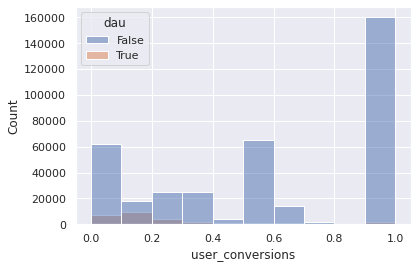

In [206]:
sns.histplot(df, x='user_conversions', hue=df['dau'] > 1, bins=10)

In [208]:
(df['mau'] > 5).describe()

count     403366
unique         2
top        False
freq      338256
Name: mau, dtype: object

In [211]:
np.quantile(df['mau'], 0.9)

9.0

### Considering outliers

In [905]:
df = df.loc[df[targets].apply(lambda x: (x < 3*x.std()) if (x.dtype == int or x.dtype == float) else x).all(axis=1)]

In [896]:
df = df.loc[df['owner'] != 'spotify']

### Multiple Criteria for Success

In [927]:
df['success'] = df[sub_targets].apply(lambda x: x > np.quantile(x, 0.75)).all(axis=1)

(0.0, 5000.0)

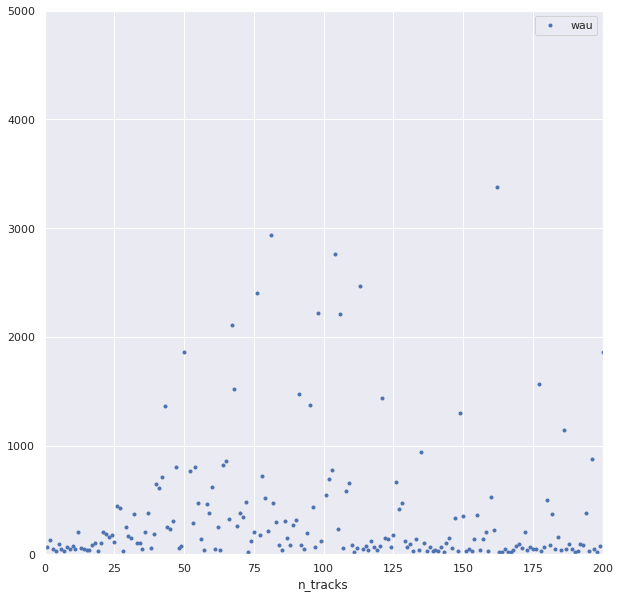

In [935]:
fig, ax = plt.subplots(figsize=(10,10))
df.loc[df['success'] == True].groupby('n_tracks')[['wau']].mean().plot(ls='', marker='.', ax=ax)
ax.set_xlim(0, 200)
ax.set_ylim(0, 5000)

In [936]:
chidf = pd.DataFrame()
target = 'success'
chidf[target] = df[target]
# quant_value = 0.90
# tar_value = np.quantile(chidf[target], quant_value)
# chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

In [941]:
chisum.loc[chisum['reject null'] == True].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
0,genre_1,Latin,3516.528142,0.000000e+00,"[[371720, 12806], [16634, 2206]]",3.849561,True
4,genre_2,Jazz,708.535543,4.164954e-156,"[[380364, 4162], [18231, 609]]",3.052841,True
1,mood_1,Lively,1287.773814,5.130420e-282,"[[375424, 9102], [17596, 1244]]",2.916028,True
14,genre_1,Children's,208.802667,2.506648e-47,"[[383079, 1447], [18639, 201]]",2.854916,True
20,genre_1,Traditional,149.152847,2.655403e-34,"[[383152, 1374], [18666, 174]]",2.599455,True
...,...,...,...,...,...,...,...
22,genre_2,Indie Rock,137.000630,1.205469e-31,"[[353648, 30878], [17772, 1068]]",0.688267,True
34,mood_1,Brooding,84.460032,3.920608e-20,"[[366942, 17584], [18247, 593]]",0.678177,True
9,genre_2,Alternative,331.424544,4.704591e-74,"[[320464, 64062], [16650, 2190]]",0.657974,True
11,mood_1,Yearning,223.850708,1.307610e-50,"[[347224, 37302], [17631, 1209]]",0.638303,True


In [952]:
ind = 'n_tracks'
target = 'wau'
mean_wau_vs_track = []
for track in range(1, 201):
    means = [] 
    for i in range(10):
        boot = random.sample(
                    list(
                        df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values),
                    k=min(len(list(
                        df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values)), 1000))
        means.append(np.mean(boot))
    mean_wau_vs_track.append(np.mean(means))

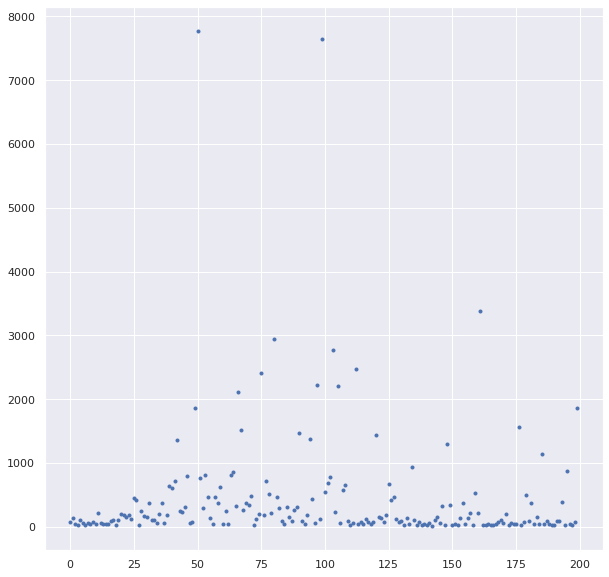

In [957]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(range(len(mean_wau_vs_track)), mean_wau_vs_track, ls='', marker='.')
# ax.set_ylim(0,5)

In [947]:
len(df.loc[
                            (df['success'] == True) 
                            & (df[ind] == track)
                        ][target].values)

14

### Dependency

In [273]:
master = pd.DataFrame()
for target in new_metrics:
    # target = sub_targets[0]
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    quant_value = 0.90
    tar_value = np.quantile(chidf[target], quant_value)
    tar_value = 0.8
    chidf[target] = chidf[target] >= tar_value
    chisum = pd.DataFrame()
    cutoff = 0.0001
    pop = chidf[target].values

    for ind in des_features:
        # ind = des_features[0]
        chidf[ind] = df[ind]

        for grp_label in df[ind].unique():
        # grp_label = df[ind].unique()[0]
            try:
                cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
                chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
                ratio = cTable[1]/cTable[0]
                pos = ratio[1]/ratio[0]
                chisum = pd.concat([chisum, pd.DataFrame([[target, ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
            except:
                pass

    chisum.columns = ['target', 'feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
    chisum = chisum.sort_values('p-value').reset_index(drop=True)
    # chisum = chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] > 2)].sort_values('multiplier', ascending=False)
    master = pd.concat((master, chisum))
    
master

,target,feature,group,chi,p-value,cTable,multiplier,reject null
0,listen_conversions,genre_1,Rap,399.045079,8.888113e-89,"[[263266, 51481], [76577, 12042]]",0.804170,True
1,listen_conversions,genre_1,Latin,340.400638,5.219381e-76,"[[303952, 10795], [84402, 4217]]",1.406803,True
2,listen_conversions,mood_1,Defiant,324.874553,1.256443e-72,"[[249581, 65166], [72706, 15913]]",0.838248,True
3,listen_conversions,genre_3,-,282.376331,2.279083e-63,"[[284762, 29985], [78481, 10138]]",1.226777,True
4,listen_conversions,genre_2,-,259.043360,2.773590e-58,"[[299145, 15602], [83015, 5604]]",1.294324,True
...,...,...,...,...,...,...,...,...
154,user_conversions,mood_1,Gritty,0.255320,6.133538e-01,"[[235846, 4671], [159649, 3200]]",1.012051,False
155,user_conversions,mood_1,Melancholy,0.183720,6.681957e-01,"[[237216, 3301], [160587, 2262]]",1.012233,False
156,user_conversions,mood_3,Gritty,0.091581,7.621766e-01,"[[233926, 6591], [158413, 4436]]",0.993866,False
157,user_conversions,mood_2,Urgent,0.026083,8.716985e-01,"[[227220, 13297], [153866, 8983]]",0.997635,False


In [276]:
master.loc[(master['reject null'] == True) & (master['multiplier'] > 1.5)]

,target,feature,group,chi,p-value,cTable,multiplier,reject null
7,listen_conversions,genre_1,New Age,136.770883,1.353331e-31,"[[313269, 1478], [87913, 706]]",1.702137,True
9,listen_conversions,mood_1,Tender,115.194233,7.135481e-27,"[[312449, 2298], [87647, 972]]",1.507851,True
18,listen_conversions,genre_2,New Age,71.594191,2.643338e-17,"[[313509, 1238], [88081, 538]]",1.546783,True
23,listen_conversions,genre_1,Children's,60.468486,7.476593e-15,"[[313592, 1155], [88126, 493]]",1.518888,True


In [281]:
master.loc[(master['reject null'] == True) & (master['multiplier'] < .5)]

,target,feature,group,chi,p-value,cTable,multiplier,reject null
0,user_conversions,genre_2,-,3922.996570,0.000000e+00,"[[223516, 17001], [158644, 4205]]",0.348479,True
1,user_conversions,genre_1,Latin,1976.239449,0.000000e+00,"[[228943, 11574], [159411, 3438]]",0.426610,True
3,user_conversions,genre_3,-,6170.632022,0.000000e+00,"[[209266, 31251], [153977, 8872]]",0.385834,True
4,user_conversions,mood_1,Lively,1155.365166,3.060886e-253,"[[232673, 7844], [160347, 2502]]",0.462844,True
11,user_conversions,genre_2,Jazz,534.239051,3.378526e-118,"[[236893, 3624], [161702, 1147]]",0.463673,True
16,user_conversions,mood_3,-,436.706320,5.640063e-97,"[[238863, 1654], [162498, 351]]",0.311941,True
18,user_conversions,mood_2,-,395.335894,5.705144e-88,"[[238982, 1535], [162516, 333]]",0.319010,True
21,user_conversions,mood_1,-,379.442742,1.645452e-84,"[[239045, 1472], [162530, 319]]",0.318734,True
23,user_conversions,mood_1,Other,340.234697,5.672282e-76,"[[239134, 1383], [162537, 312]]",0.331911,True
26,user_conversions,mood_1,Tender,313.405005,3.958040e-70,"[[238072, 2445], [162024, 825]]",0.495797,True


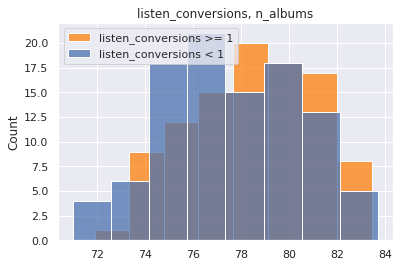

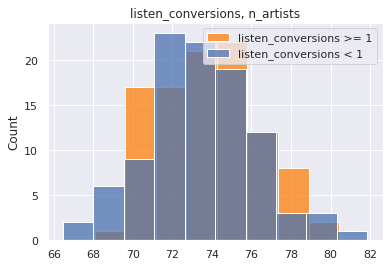

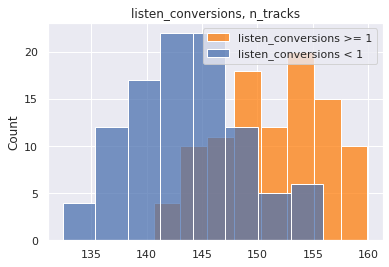

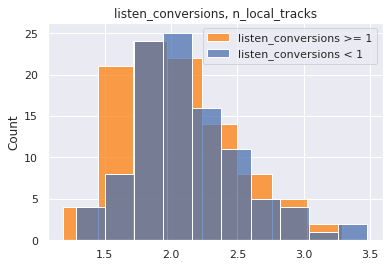

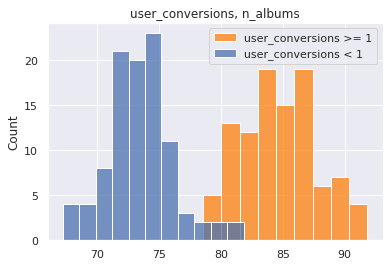

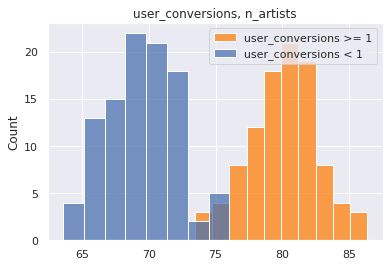

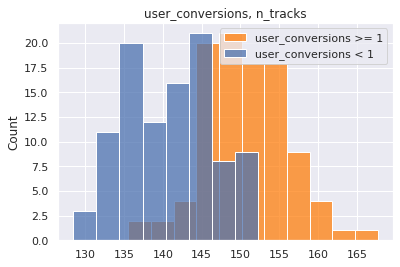

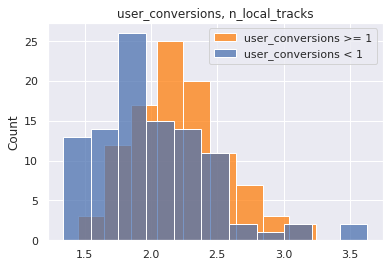

,target,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,listen_conversions,n_tracks,10.791139,1.289400e-21,151.33751,143.74398,True
1,listen_conversions,n_albums,2.441572,1.550563e-02,78.52885,77.60380,False
2,listen_conversions,n_local_tracks,-1.514198,1.315704e-01,2.04345,2.13447,False
3,listen_conversions,n_artists,1.186743,2.367580e-01,73.94089,73.48707,False
0,user_conversions,n_artists,29.009043,3.528897e-73,80.09057,69.51769,True
1,user_conversions,n_albums,27.865311,5.520382e-70,84.69724,73.45058,True
2,user_conversions,n_tracks,12.465380,1.108146e-26,150.70376,140.85719,True
3,user_conversions,n_local_tracks,3.208929,1.563093e-03,2.20957,2.02793,False


In [269]:
new_master = pd.DataFrame()
for target in new_metrics:
    # target = sub_targets[2]
    chidf = pd.DataFrame()
    chidf[target] = df[target]
    chidf['n_tracks'] = df['n_tracks']
    quant_value = 0.90
    tar_value = np.quantile(chidf[target], quant_value)
    tar_value = 0.8
    chidf[target] = chidf[target] >= tar_value
    welchsum = pd.DataFrame()
    cutoff = 0.0001
    pop = chidf[target].values

    for ind in con_features:
        # ind = con_features[0]
        chidf[ind] = df[ind]

        # for grp_label in df[ind].unique():
        # try:
        a = []
        b = []
        for i in range(100):
            boot1 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == True)
                                & (chidf['n_tracks'] > 9)
                                & (chidf['n_tracks'] < 999)
                            ][ind].values),
                        k=1000)
            boot2 = random.sample(
                        list(
                            chidf.loc[
                                (chidf[target] == False)
                                & (chidf['n_tracks'] > 9)
                                & (chidf['n_tracks'] < 999)
                            ][ind].values),
                        k=1000)
            a.append(np.mean(boot1))
            b.append(np.mean(boot2))
        testt, p = stats.ttest_ind(a, b, equal_var=False)
        a_avg = np.mean(a)
        b_avg = np.mean(b)
        welchsum = pd.concat([welchsum, pd.DataFrame([[target, ind, testt, p, a_avg, b_avg, p<cutoff]])])
        sns.histplot(a, color='tab:orange', label=f"{target} >= {tar_value:.0f}")
        sns.histplot(b, label=f"{target} < {tar_value:.0f}")
        plt.title(f"{target}, {ind}")
        plt.legend()
        plt.show()
        # except:
        #     pass

    welchsum.columns = ['target', 'feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
    welchsum = welchsum.sort_values('p-value').reset_index(drop=True)
    new_master = pd.concat((new_master, welchsum))
new_master

## Conclusions

### Discrete, Independent Variables

We note that there is class imbalance in the discrete independent variables:

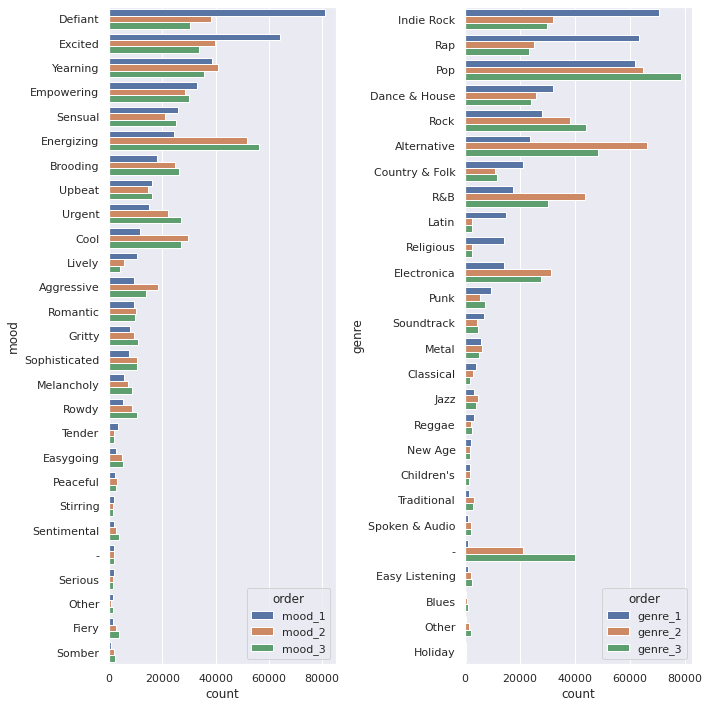

In [702]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

dff = pd.DataFrame(df[des_features[0]].value_counts()).join(
    pd.DataFrame(df[des_features[1]].value_counts())).join(
    pd.DataFrame(df[des_features[2]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['mood', 'order', 'count']
sns.barplot(data=dff, hue='order', y='mood', x='count', orient='h', ax=ax[0])

dff = pd.DataFrame(df[des_features[3]].value_counts()).join(
    pd.DataFrame(df[des_features[4]].value_counts())).join(
    pd.DataFrame(df[des_features[5]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['genre', 'order', 'count']
sns.barplot(data=dff, hue='order', y='genre', x='count', orient='h', ax=ax[1])

plt.tight_layout()

This class imbalance can have a variety of effects (and might be derived from a variety of sources).

For example, users will have more choice when listening to popular genres likeIndie Rock and Rap, and less choice with genres like Blues and Easy listening. As it so happens, when we look to the relationship between genre/mood and the dependent variables, many of the genre/moods with smaller class sizes will have a positive multiplier effect on the dependent variable

### Continuous, Independent Variables

The four continuous variables of focus in this dataset are highly tailed. Due to this, our statistical tests will require bootstrapping.

removed items: 404


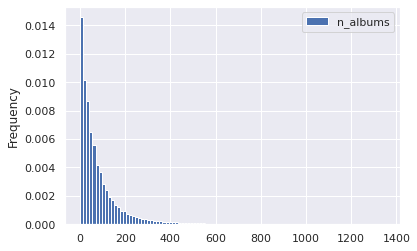

removed items: 405


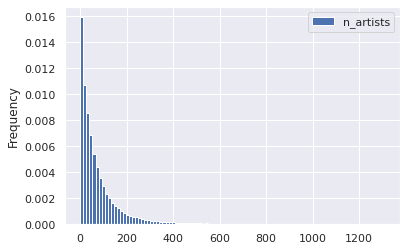

removed items: 404


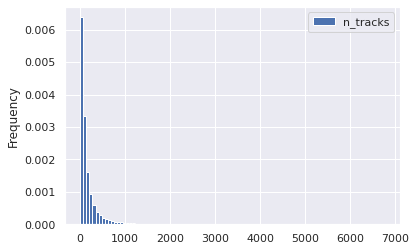

removed items: 406


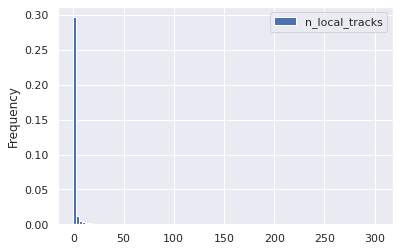

In [704]:
quant = 0.999
con_features = ['n_albums', 'n_artists', 'n_tracks', 'n_local_tracks']
for target in con_features:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100, density=True)
    plt.show()

an example of bootstrapping `n_albums`

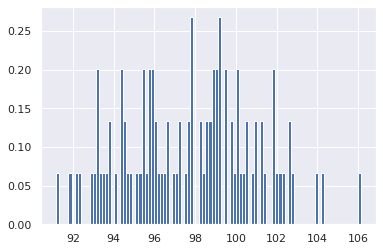

In [705]:
means = []
ind = con_features[0]
for i in range(100):
    boot = random.sample(
                list(
                    df.loc[
                        (df[ind] > 9) 
                        & (df[ind] < 999)
                    ][ind].values),
                k=1000)
    means.append(np.mean(boot))
stuff = plt.hist(means, bins=100, density=True)

### Discrete, Dependent Variables

For the purposes of investigating a "successful" playlist, there are 5 primary metrics:

In [765]:
targets

['streams',
 'stream30s',
 'dau',
 'wau',
 'mau',
 'mau_previous_month',
 'mau_both_months',
 'users',
 'skippers',
 'monthly_stream30s',
 'monthly_owner_stream30s']

In [777]:
df[sub_targets].describe().round(1).to_excel("file.xlsx")

and "top" performers in each of these metrics were based on top 10% and top 1% quantiles:

In [717]:
print('p99 targets')
for target in sub_targets:
    space = ' '* (20 - len(str(target)))
    print(f"{target}: {space} {np.quantile(df[target], 0.99)}")
print()
print('p90 targets')
for target in sub_targets:
    space = ' '* (20 - len(str(target)))
    print(f"{target}: {space} {np.quantile(df[target], 0.90)}")

p99 targets
mau_previous_month:    130.0
mau_both_months:       19.0
mau:                   143.0
monthly_stream30s:     2843.0
stream30s:             113.0

p90 targets
mau_previous_month:    9.0
mau_both_months:       2.0
mau:                   9.0
monthly_stream30s:     432.0
stream30s:             17.0


You can imagine with these metrics, some concerns are:

* what if a playlist was made in the current month, or even current day?
    * playlist is not properly represented by the data
* how do we normalize by playlists that already have a high visibility? i.e. what if a playlist is "good" but just isn't getting noticed?
    * can compute conversion metrics:
        * 30 second listens / total listens
        * mau both months / mau previous month
        
While noting these shortcomings, to keep the analysis focused I singled out the previously mentioned targets, with a focus on `monthly_stream30s` as the north star metric. `monthly_stream30s` is advantageous as a nort star metric since it contains data from the entire month (reducing variance) only contains relevant listens (greater than 30 seconds long). Some disadvantages of this metric are that it doesn't account for just a few listeners who may be providing the majority of listens, and playlists that were made in the current month will be undervalued.

### Dependency

#### Chi Square

In the chi-square test, the contigency table was used to calculate a `multiplier` effect. This is a ratio of ratios: the count of upper quantile over bottom quantile for the given group over the count of upper quantile over bottom quantile for non-group. In other words, it articulates how much more likely a sample in the given group is likely to be in the upper quantile vs a sample not in the given group

In [737]:
chisq_results = pd.read_csv("chi_square_results.csv", index_col=0)
chisq_results.head()

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
12,stream30s,0.99,113.0,mood_3,-,125.854082,3.309444e-29,[[397434 1935]\n [ 3927 70]],3.661181,True,0
11,monthly_stream30s,0.99,2843.0,mood_2,-,109.163417,1.494430e-25,[[397529 1804]\n [ 3969 64]],3.553294,True,0
67,mau_previous_month,0.90,9.0,genre_1,-,95.863487,1.230846e-22,[[365249 769]\n [ 37173 175]],2.236007,True,0
10,monthly_stream30s,0.99,2843.0,mood_1,-,112.668942,2.549855e-26,[[397605 1728]\n [ 3970 63]],3.651389,True,0
7,stream30s,0.99,113.0,mood_1,-,141.501726,1.249779e-32,[[397646 1723]\n [ 3929 68]],3.994277,True,0


In [736]:
chisq_results['target'].unique()

array(['stream30s', 'monthly_stream30s', 'mau_previous_month', 'mau',
       'mau_both_months'], dtype=object)

In [738]:
chisq_results['upper q'].unique()

array([0.99, 0.9 ])

Taking together the five targets, the two upper quantiles, and the six categorical independent variables, we can identify which group occured the most frequently as a variable of influence:

In [781]:
chisq_results.loc[(chisq_results['feature'].str.contains('genre'))
                & (chisq_results['group'] != '-')]['group'].value_counts()

Traditional       16
Children's        16
Jazz              14
Latin             12
Easy Listening     8
Soundtrack         8
New Age            7
Holiday            6
Spoken & Audio     4
Other              2
Name: group, dtype: int64

Using these value counts as a "rank" we can then groupby this rank and see how each group is influencing the propensity to be in the upper quadrant

Taking "Romantic" as an example, we see that it's multiplier effect is relatively consistent across the five targets and two quantiles:

In [741]:
sort_key = {i: j for i,j in zip(chisq_results['group'].value_counts().index.values, range(chisq_results['group'].nunique()))}
chisq_results['rank'] = chisq_results['group'].apply(lambda x: sort_key[x])
chisq_results.sort_values('rank', inplace=True)
# chisq_results.drop('rank', axis=1, inplace=True)
chisq_results.loc[chisq_results['group'] != '-'][:20]

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
3,mau_both_months,0.99,19.0,mood_1,Romantic,109.693770,1.143607e-25,[[390177 9231]\n [ 3766 192]],2.154933,True,1
5,mau_previous_month,0.90,9.0,mood_2,Romantic,1379.938658,4.806442e-302,[[357822 8196]\n [ 35327 2021]],2.497610,True,1
8,stream30s,0.99,113.0,mood_1,Romantic,139.245969,3.891401e-32,[[390152 9217]\n [ 3791 206]],2.300158,True,1
6,mau_previous_month,0.99,130.0,mood_2,Romantic,104.434543,1.624732e-24,[[389323 10013]\n [ 3826 204]],2.073152,True,1
6,mau,0.90,9.0,mood_1,Romantic,1328.179994,8.498925e-291,[[355892 7442]\n [ 38051 1981]],2.489700,True,1
5,mau,0.99,143.0,mood_3,Romantic,122.574129,1.728356e-28,[[389664 9685]\n [ 3810 207]],2.185929,True,1
10,stream30s,0.99,113.0,mood_3,Romantic,136.025552,1.969792e-31,[[389689 9680]\n [ 3785 212]],2.254825,True,1
6,mau_previous_month,0.90,9.0,mood_1,Romantic,1142.816205,1.633755e-250,[[358408 7610]\n [ 35535 1813]],2.402893,True,1
6,monthly_stream30s,0.99,2843.0,mood_3,Romantic,149.750731,1.965370e-34,[[389660 9673]\n [ 3814 219]],2.313066,True,1
4,monthly_stream30s,0.99,2843.0,mood_1,Romantic,175.072639,5.772239e-40,[[390131 9202]\n [ 3812 221]],2.457919,True,1


In [784]:
chisq_results.loc[(chisq_results['group'] == 'Traditional')
                 & (chisq_results['target'] == 'monthly_stream30s')]

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
36,monthly_stream30s,0.99,2843.0,genre_3,Traditional,29.032918,7.115879e-08,[[396376 2957]\n [ 3973 60]],2.024364,True,3
27,monthly_stream30s,0.99,2843.0,genre_2,Traditional,47.457479,5.621008e-12,[[396211 3122]\n [ 3962 71]],2.274246,True,3


Let's use this idea of average multiplier effect, and average chi-square statistic to summarize by group.

Sorting by the test statistic, we see the top 5 most influential groups:

In [754]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('chi', ascending=False)[:10]

,chi,multiplier,rank
group,,,
Latin,1686.610898,3.001282,6.0
-,766.884882,3.049100,0.0
Sophisticated,581.181538,2.055203,18.0
Lively,523.373076,2.364492,2.0
Romantic,493.442950,2.318001,1.0
Soundtrack,345.506268,2.209295,9.0
Jazz,323.657066,2.342954,5.0
Fiery,261.957158,2.244027,15.0
Tender,212.399270,3.033890,16.0


Sorting instead by the multiplier, we can see which group has the _heaviest_ influence

In [755]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('multiplier', ascending=False)[:10]

,chi,multiplier,rank
group,,,
-,766.884882,3.049100,0.0
Tender,212.399270,3.033890,16.0
Latin,1686.610898,3.001282,6.0
Children's,165.058604,2.871261,4.0
Holiday,41.741338,2.836528,12.0
New Age,75.783147,2.754796,10.0
Spoken & Audio,163.859264,2.610393,14.0
Peaceful,61.046237,2.564297,13.0
Other,166.299708,2.425104,11.0


Sorting instead by rank, we see which groups show up most frequently

In [756]:
chisq_results.groupby('group')[['chi', 'multiplier', 'rank']].mean().sort_values('rank', ascending=True)[:10]

,chi,multiplier,rank
group,,,
-,766.884882,3.049100,0.0
Romantic,493.442950,2.318001,1.0
Lively,523.373076,2.364492,2.0
Traditional,176.194741,2.361342,3.0
Children's,165.058604,2.871261,4.0
Jazz,323.657066,2.342954,5.0
Latin,1686.610898,3.001282,6.0
Serious,103.700606,2.190306,7.0
Easy Listening,99.533804,2.407295,8.0


In [786]:
chisq_results.loc[chisq_results['target'] == 'monthly_stream30s']

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
14,monthly_stream30s,0.99,2843.0,mood_3,-,95.615882,1.394829e-22,[[397392 1941]\n [ 3969 64]],3.301357,True,0
3,monthly_stream30s,0.99,2843.0,genre_1,-,198.911522,3.608821e-45,[[398442 891]\n [ 3980 53]],5.954979,True,0
10,monthly_stream30s,0.99,2843.0,mood_1,-,112.668942,2.549855e-26,[[397605 1728]\n [ 3970 63]],3.651389,True,0
11,monthly_stream30s,0.99,2843.0,mood_2,-,109.163417,1.494430e-25,[[397529 1804]\n [ 3969 64]],3.553294,True,0
6,monthly_stream30s,0.99,2843.0,mood_3,Romantic,149.750731,1.965370e-34,[[389660 9673]\n [ 3814 219]],2.313066,True,1
4,monthly_stream30s,0.99,2843.0,mood_1,Romantic,175.072639,5.772239e-40,[[390131 9202]\n [ 3812 221]],2.457919,True,1
7,monthly_stream30s,0.99,2843.0,mood_2,Romantic,146.934024,8.112487e-34,[[389339 9994]\n [ 3810 223]],2.280176,True,1
22,monthly_stream30s,0.99,2843.0,mood_2,Lively,62.570224,2.571115e-15,[[393976 5357]\n [ 3920 113]],2.120023,True,2
5,monthly_stream30s,0.99,2843.0,mood_1,Lively,172.134248,2.529542e-39,[[389222 10111]\n [ 3798 235]],2.381860,True,2
36,monthly_stream30s,0.99,2843.0,genre_3,Traditional,29.032918,7.115879e-08,[[396376 2957]\n [ 3973 60]],2.024364,True,3


It creates some fog to jumble together mood/genres this way. We can instead separate them and ask questions like:

##### What is the most influential primary genre on monthly streams over 30 seconds?

Answer: Children's followed by Latin

Reason: both genre's appear as influential in other guardrail metrics (high rank), have high test statistics, and are influential in both p99 and p90 with multiplier effects of [4.8, 2.6] and [3.1, 2.1], respectively.

In [752]:
chisq_results.loc[(chisq_results['feature'] == 'genre_1')
                 & (chisq_results['target'] == 'monthly_stream30s')]

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
3,monthly_stream30s,0.99,2843.0,genre_1,-,198.911522,3.608821e-45,[[398442 891]\n [ 3980 53]],5.954979,True,0
2,monthly_stream30s,0.99,2843.0,genre_1,Children's,207.229586,5.524721e-47,[[397760 1573]\n [ 3958 75]],4.791570,True,4
6,monthly_stream30s,0.90,432.0,genre_1,Children's,262.624693,4.596280e-59,[[361785 1286]\n [ 39933 362]],2.550270,True,4
0,monthly_stream30s,0.99,2843.0,genre_1,Latin,537.892273,5.419582e-119,[[384749 14584]\n [ 3605 428]],3.132127,True,6
0,monthly_stream30s,0.90,432.0,genre_1,Latin,1150.625294,3.280867e-252,[[350782 12289]\n [ 37572 2723]],2.068731,True,6
29,monthly_stream30s,0.99,2843.0,genre_1,Easy Listening,40.400033,2.069376e-10,[[398435 898]\n [ 4004 29]],3.213550,True,8
20,monthly_stream30s,0.99,2843.0,genre_1,Soundtrack,66.073066,4.345131e-16,[[392575 6758]\n [ 3897 136]],2.027276,True,9
28,monthly_stream30s,0.99,2843.0,genre_1,New Age,43.730647,3.768245e-11,[[397202 2131]\n [ 3980 53]],2.482109,True,10
12,monthly_stream30s,0.90,432.0,genre_1,New Age,166.484617,4.335181e-38,[[361286 1785]\n [ 39896 399]],2.024214,True,10
52,monthly_stream30s,0.99,2843.0,genre_1,Spoken & Audio,19.783961,8.670724e-06,[[398209 1124]\n [ 4006 27]],2.387798,True,14


##### What is the most influential primary mood on monthly streams over 30 seconds?

Answer: Romantic and Lively

Reason: Romantic and Lively moods appear multiple times as highly influential (high rank) they have high multipliers. A contendent may be Tender, as it has a high multiplier effect as well at 3.75

In [753]:
chisq_results.loc[(chisq_results['feature'] == 'mood_1')
                 & (chisq_results['target'] == 'monthly_stream30s')]

,target,upper q,upper q value,feature,group,chi,p-value,cTable,multiplier,reject null,rank
10,monthly_stream30s,0.99,2843.0,mood_1,-,112.668942,2.549855e-26,[[397605 1728]\n [ 3970 63]],3.651389,True,0
4,monthly_stream30s,0.99,2843.0,mood_1,Romantic,175.072639,5.772239e-40,[[390131 9202]\n [ 3812 221]],2.457919,True,1
5,monthly_stream30s,0.99,2843.0,mood_1,Lively,172.134248,2.529542e-39,[[389222 10111]\n [ 3798 235]],2.381860,True,2
33,monthly_stream30s,0.99,2843.0,mood_1,Other,30.443472,3.437382e-08,[[397678 1655]\n [ 3993 40]],2.407101,True,11
11,monthly_stream30s,0.90,432.0,mood_1,Other,197.598843,6.979647e-45,[[361719 1352]\n [ 39952 343]],2.296943,True,11
26,monthly_stream30s,0.99,2843.0,mood_1,Peaceful,47.834009,4.638752e-12,[[397055 2278]\n [ 3976 57]],2.498765,True,13
1,monthly_stream30s,0.99,2843.0,mood_1,Tender,218.759022,1.686848e-49,[[396180 3153]\n [ 3916 117]],3.754151,True,16


##### Which Categorical Feature is most influential overall?

Answer: genre_1, followed by genre_2 and mood_1

Reason: we see that these features appear multiple times across the 5 different targets and 2 different quantiles

In [757]:
chisq_results['feature'].value_counts()

genre_1    48
genre_2    39
mood_1     34
mood_2     28
mood_3     17
genre_3    16
Name: feature, dtype: int64

##### What are the shortcomings of this analysis?

We haven't taken into account confounding variables. For example, perhaps Latin genre is typically associated with Lively mood. Then which variable is it that actually contributes to a highly performing playlist? We have strategies for dealing with this. We can stratify the confounding variables by over or under sampling. We can also consider them together in a forward selection logistic model. We will take the latter approach later on in the analysis.

We haven't considered the categorical variables alongside the continuous variables, so we don't know how they fit overall in terms of relative improtance. We will approach this the same way as the confounding variables issue, and incorporate all variables in a logistic regression.

#### t-Test

In [759]:
ttest_results = pd.read_csv("t_test_results.csv", index_col=0)
ttest_results.head()

,target,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,mau_previous_month,n_albums,-25.318099,4.772854e-63,69.77939,78.70629,True
1,mau_previous_month,n_artists,-15.418330,9.408966e-36,68.08641,73.90254,True
2,mau_previous_month,n_local_tracks,-9.550137,7.728853e-18,1.60489,2.07692,True
3,mau_previous_month,n_tracks,6.086774,5.913654e-09,149.50371,145.10534,True
0,mau_both_months,n_artists,52.402365,2.845239e-114,91.41907,71.97618,True


#### Models

In [728]:
log_results = pd.read_csv("../../scripts/fwd_selection_results.txt", header=None, index_col=0)
log_results.columns = ['feature', 'pseudo r2']
log_results.reset_index(inplace=True, drop=True)
log_results.drop(0, axis=0, inplace=True)
log_results

,feature,pseudo r2
1,intercept,2.197000e-12
2,n_albums,2.614000e-02
3,genre_1_Latin,3.093000e-02
4,genre_1_Indie Rock,3.274000e-02
5,genre_1_Rap,3.431000e-02
6,genre_1_Dance & House,3.568000e-02
7,genre_1_Rock,3.674000e-02
8,mood_1_Energizing,3.772000e-02
9,genre_1_Children's,3.863000e-02
10,mood_1_Tender,3.931000e-02


In [764]:
target = "monthly_stream30s"
y = df[target].values
labels = y.copy()
names = []
weights = y.copy()
weights.dtype = 'float'
lim = 11
dom_class_weight = 1 / (lim - 1 - 1)
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx < lim - 2:
        prev = quant
        continue
    elif idx == lim - 2:
        weights[y <= np.quantile(y, quant)] = dom_class_weight
        labels[labels <= np.quantile(y, quant)] = 0
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
        
    else:
        labels[(labels > np.quantile(y, prev))
              & (labels <= np.quantile(y, quant))] = 1
        weights[(y > np.quantile(y, prev))
              & (y <= np.quantile(y, quant))] = 1.0
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

basemodel = pd.read_csv("../../scripts/basemodel.csv", index_col = 0)
X2 = basemodel.values
est = Logit(y, X2)
est2 = est.fit(disp=0)
summ = est2.summary()

res_table = summ.tables[1]
res_df = pd.DataFrame(res_table.data)
cols = res_df.iloc[0]
cols = [str(i) for i in cols]
res_df.drop(0, axis=0, inplace=True)
res_df.set_index(0, inplace=True)
res_df.columns = cols[1:]
res_df.index = basemodel.columns
res_df

,coef,std err,z,P>|z|,[0.025,0.975]
intercept,-2.0919,0.012,-180.211,0.000,-2.115,-2.069
n_albums,0.2659,0.012,21.370,0.000,0.241,0.290
genre_1_Latin,0.5389,0.025,21.354,0.000,0.489,0.588
genre_1_Indie Rock,-0.5919,0.020,-30.130,0.000,-0.630,-0.553
genre_1_Rap,-0.3552,0.018,-19.651,0.000,-0.391,-0.320
genre_1_Dance & House,-0.3364,0.023,-14.444,0.000,-0.382,-0.291
genre_1_Rock,-0.4325,0.024,-18.072,0.000,-0.479,-0.386
mood_1_Energizing,-0.3012,0.026,-11.592,0.000,-0.352,-0.250
genre_1_Children's,0.7694,0.061,12.545,0.000,0.649,0.890
mood_1_Tender,0.6086,0.053,11.496,0.000,0.505,0.712


## The simplified, final approach